# ML_BMS_2023 Final Project Analysis

### Data Loading

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
from fooof import FOOOFGroup
import os 
import joblib
import emd
import re
# import statsmodels.formula.api as smf
# import statsmodels.api as sm
import pandas as pd
import pickle



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GitHub/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [2]:
subj_ids = ['MS003', 'MS016','MS017','MS019','MS020']
subj_formats = ['edf', 'edf', 'edf', 'edf', 'edf']

In [24]:
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/'
anat_path = base_dir + '/data/anat/'
ephys_path = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/'
behav_raw = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/behav/raw/'
behav_clean = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/behav/preprocessed/'

In [50]:
epochs_all_subjs_all_evs = pd.read_pickle(rf'{ephys_path}/epochs_epochs.pkl')
baseline_power_epochs = pd.read_pickle(rf'{ephys_path}/baseline_epochs.pkl')
power_epochs = pd.read_pickle(rf'{ephys_path}/power_epochs.pkl')


/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_44509/126448802.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_44509/126448802.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_44509/126448802.py:47: SettingWithCopyWarning: 
A value is 

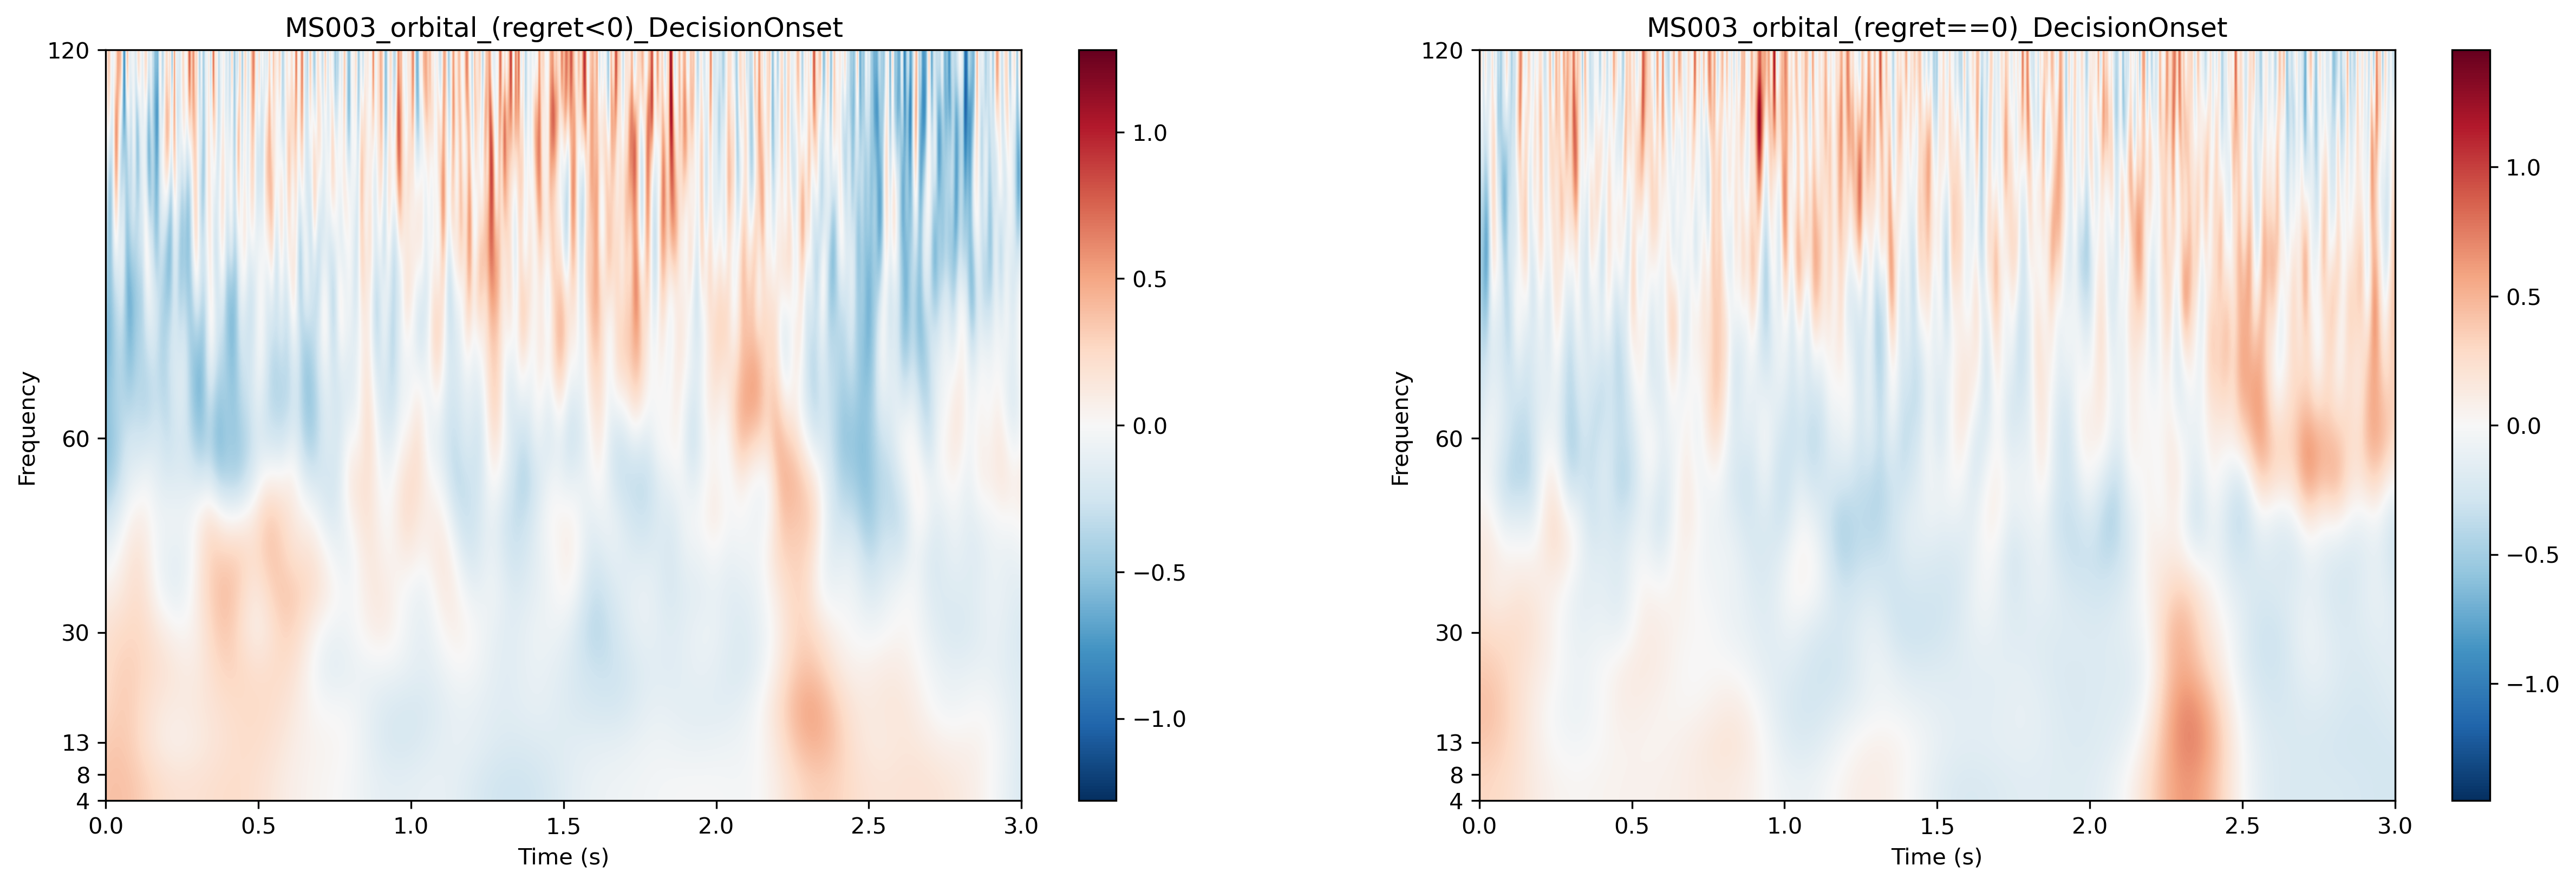

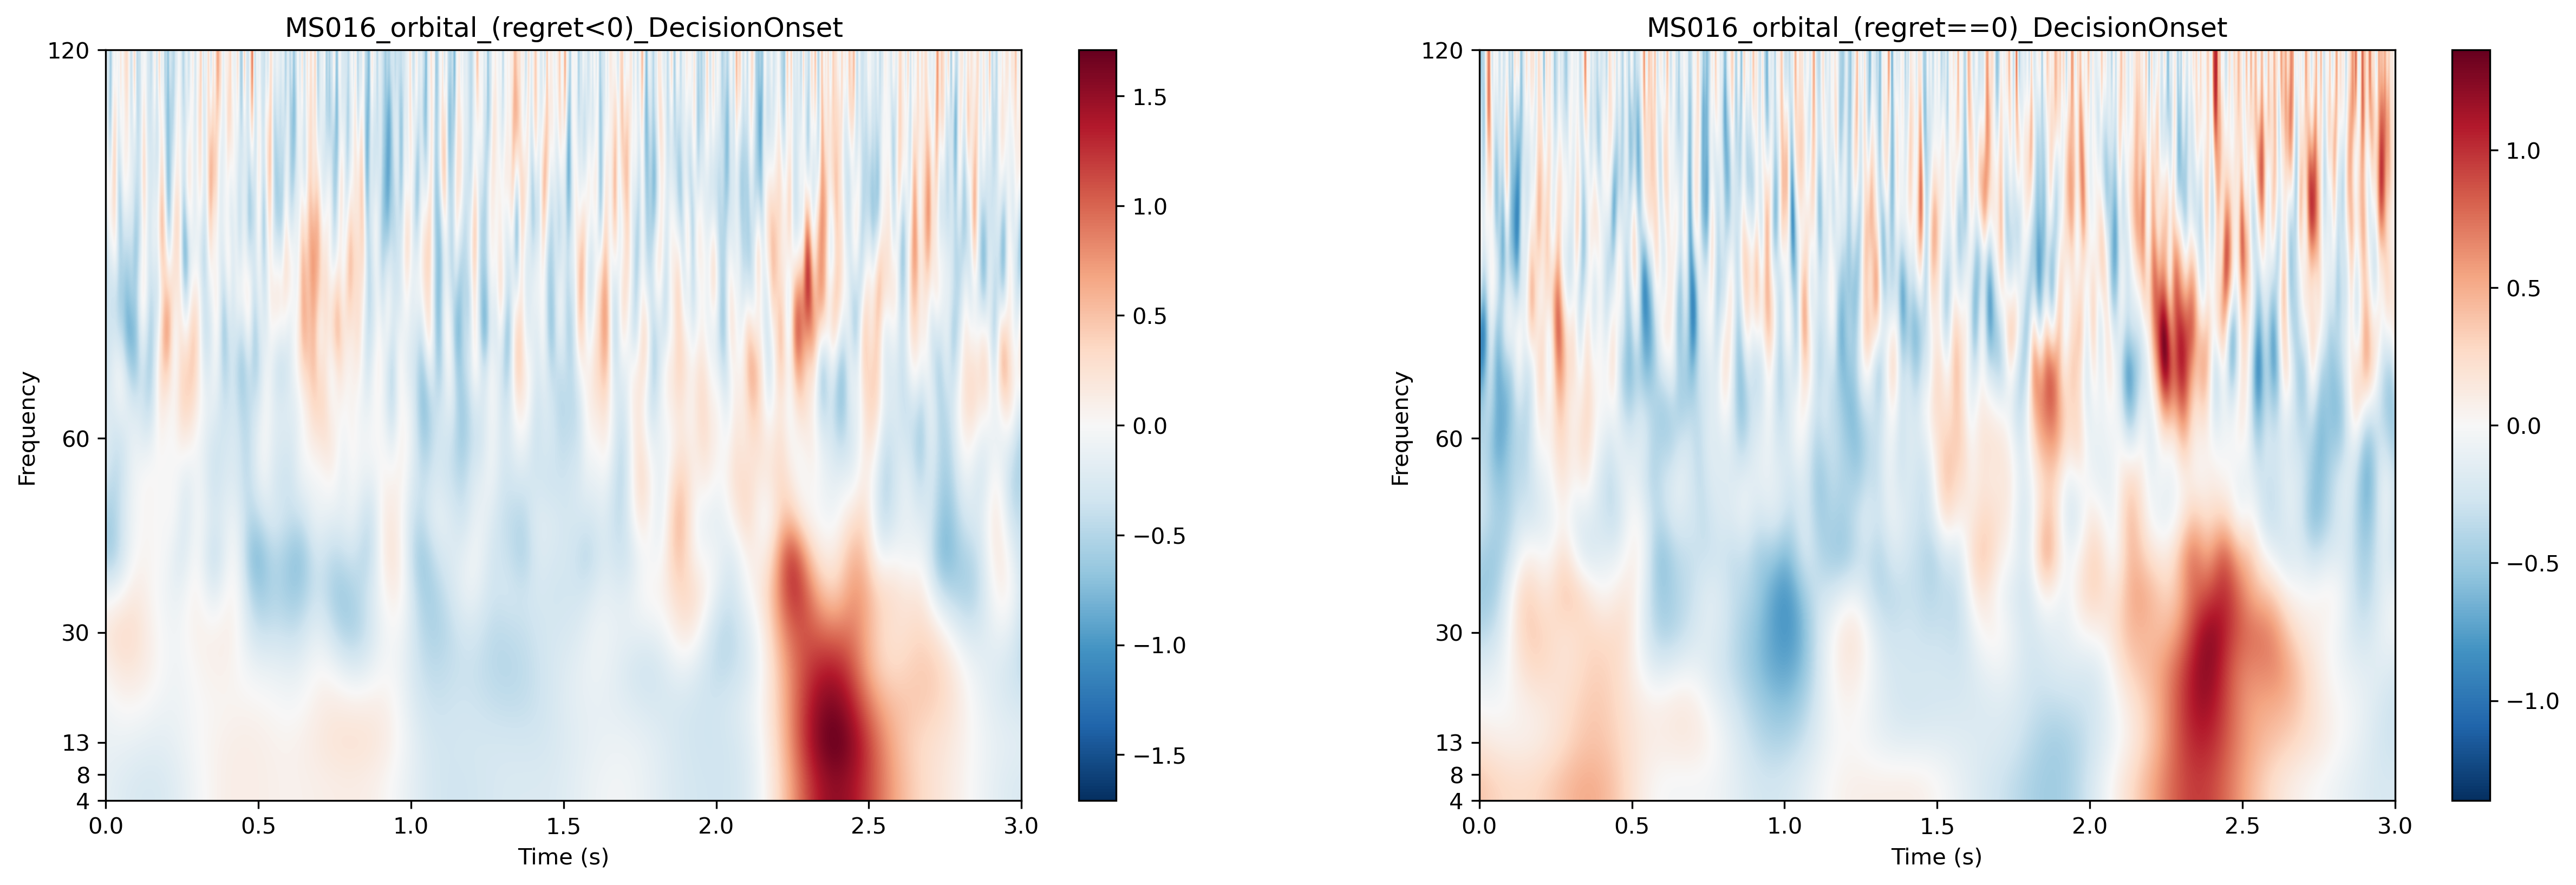

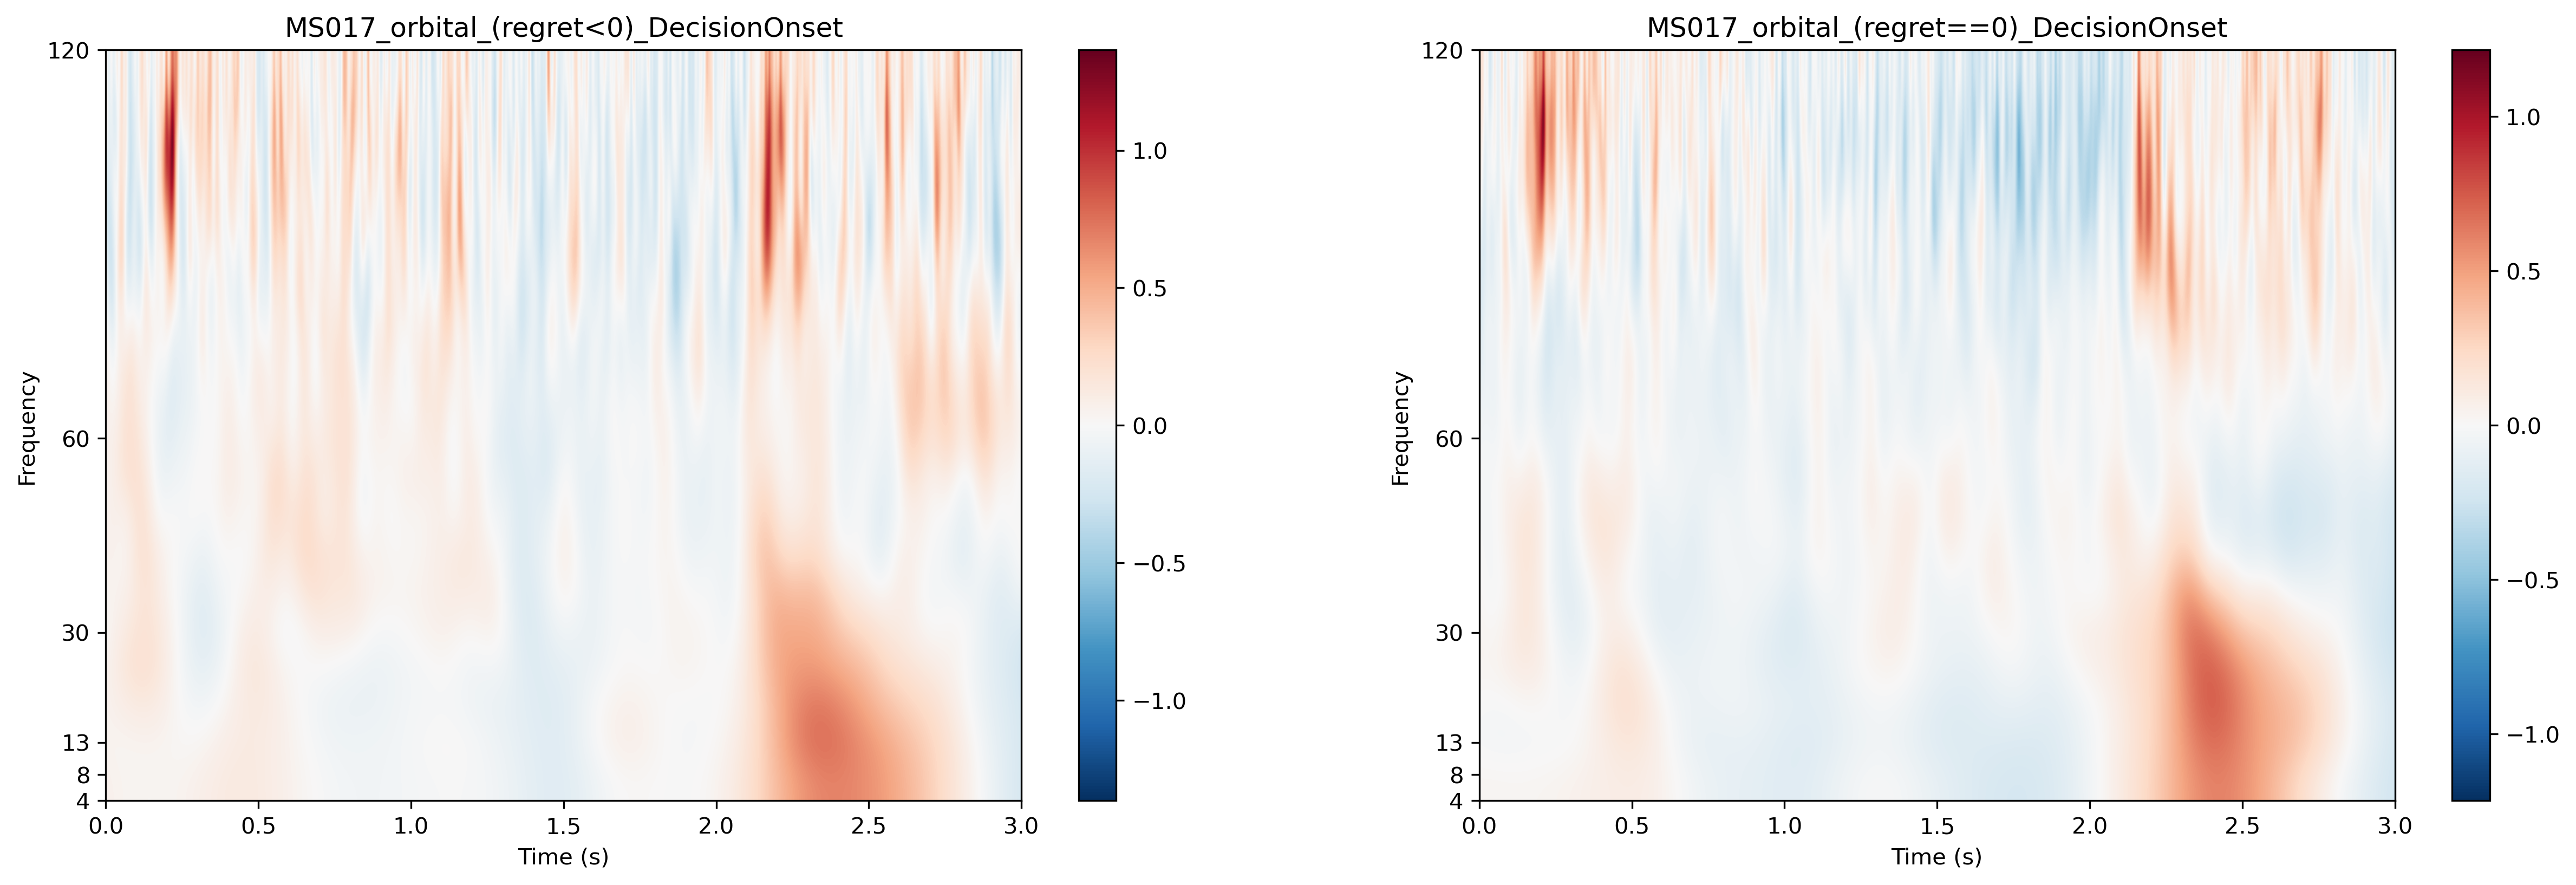

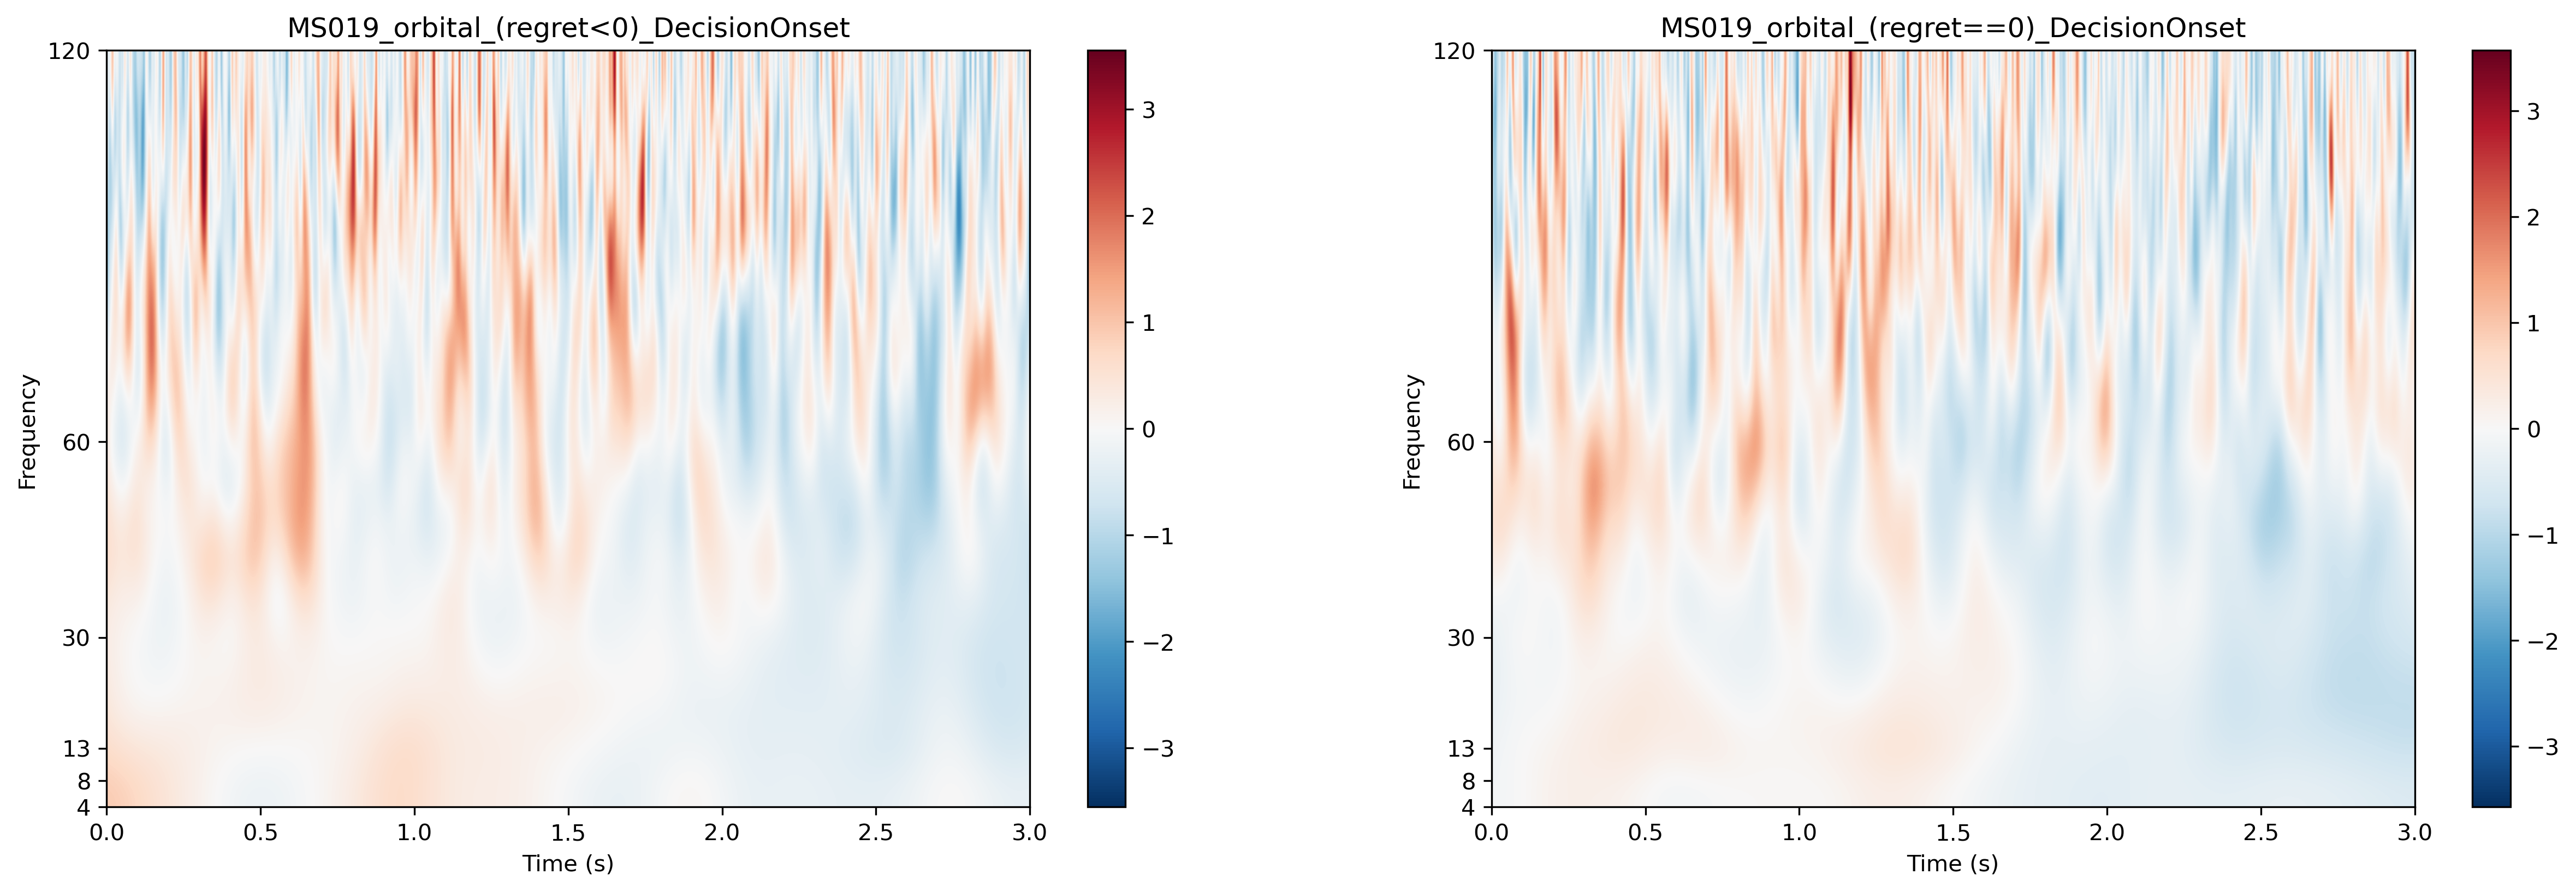

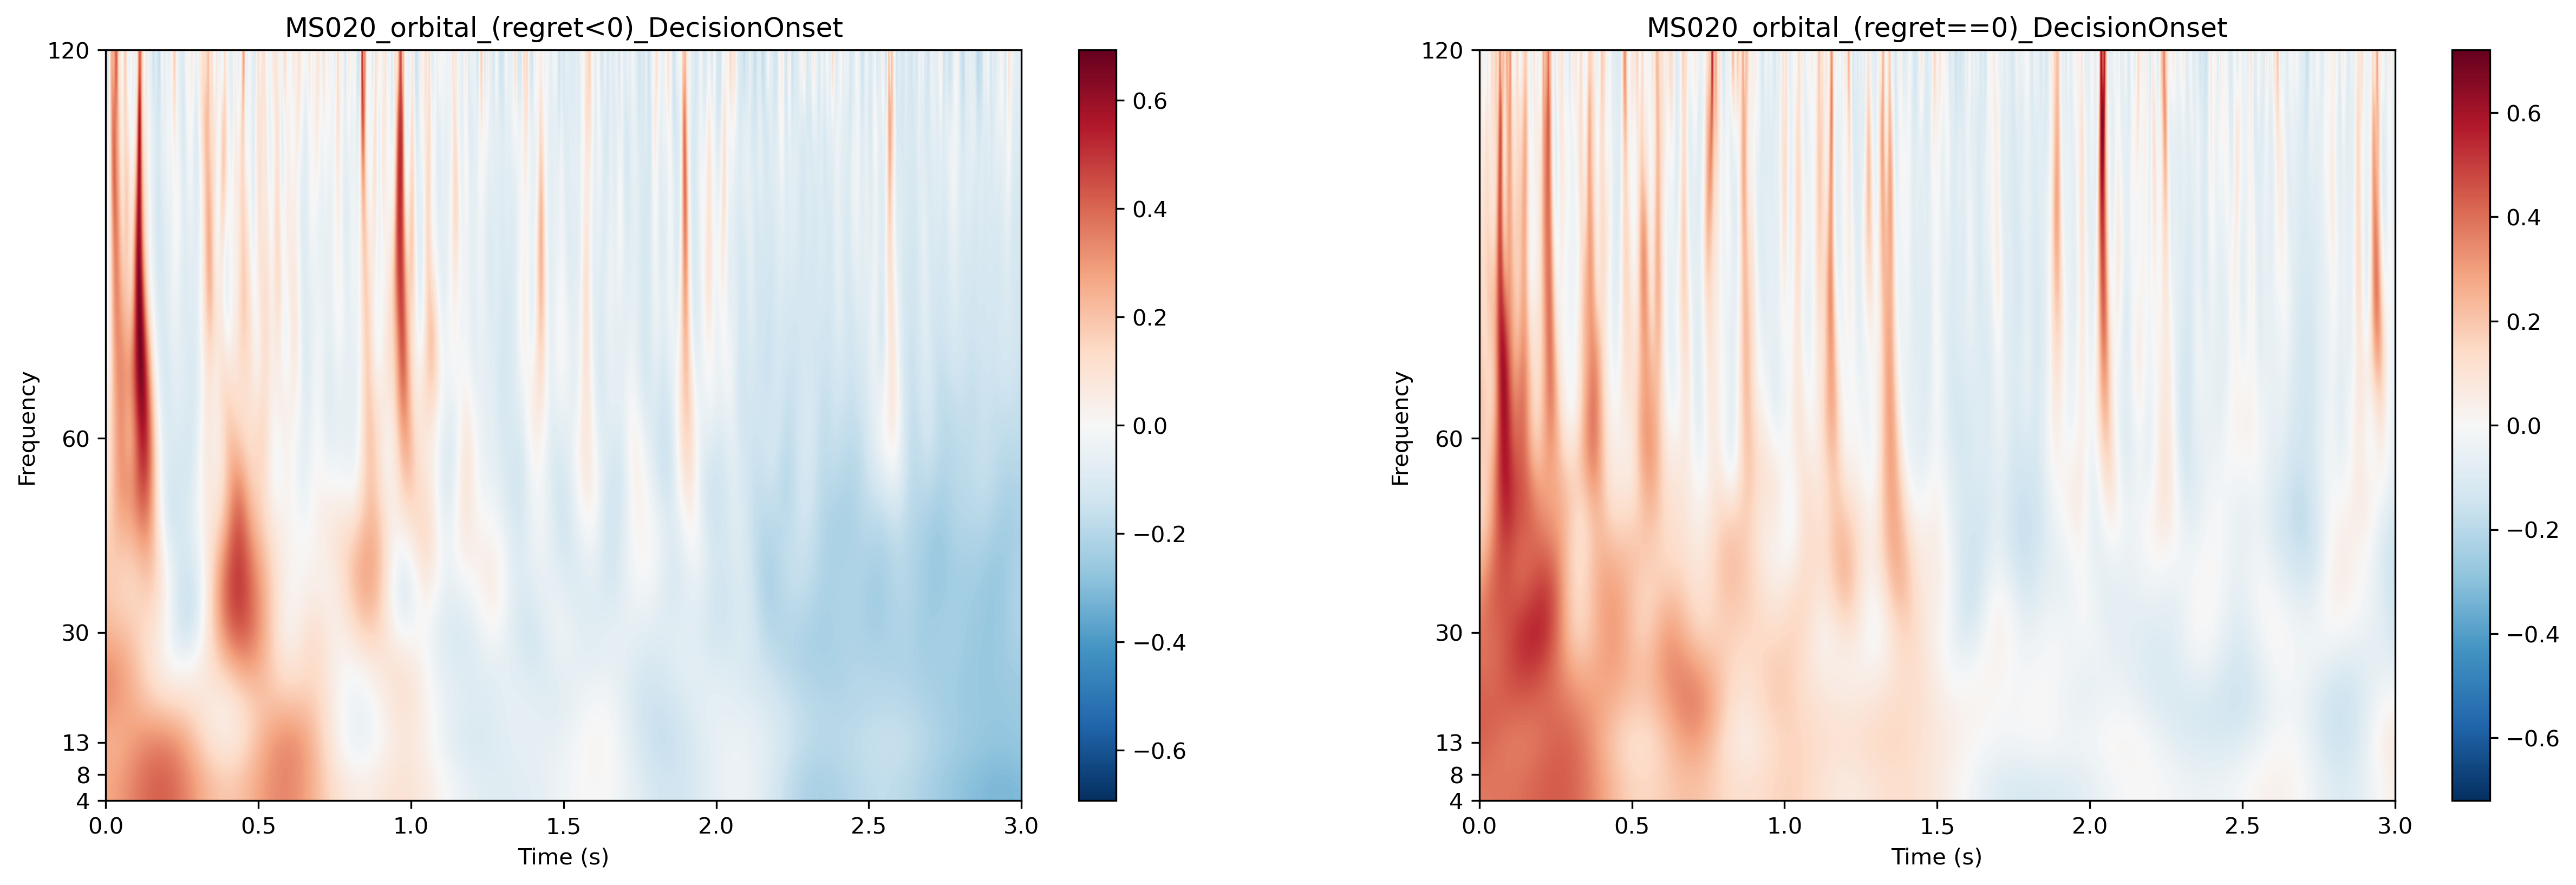

In [88]:
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}
for i in analysis_evs: 
    if i not in evs.keys(): 
        raise ValueError('This analysis event is not in the dictionary')
event = 'DecisionOnset'

# rois = ['hippocampus', 'amygdala', 'insular', 'cingulate' ,'orbital']
region = 'orbital'

# band definitions for y-axis
yticks = [4, 8, 13, 30, 60, 120]

# task condition to contrast 
#conditions = ["(outcome=='good')",
 #            "(outcome=='bad')"]

#cond_name = 'outcome'

# task condition to contrast 
conditions = ["(regret<0)",
              "(regret==0)"]


cond_name = 'regret'

for subj_id in subj_ids:
    save_path = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/' + subj_id #save path 
    # Get electrode df 
    elec_file = anat_path + subj_id + '_labels.csv'

    elec_data = lfp_preprocess_utils.load_elec(elec_file)

    # Set some spectrogram parameters 
    freqs = np.logspace(*np.log10([4, 120]), num=20)
    n_cycles = 4  
    sr = epochs_all_subjs_all_evs[subj_id][baseline_ev].info['sfreq']
    buf = 1.0
    buf_ix = int(buf*sr)

    event = 'DecisionOnset'

    anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
    elec_data = elec_data.dropna(how='all')

    picks = analysis_utils.select_picks_rois(elec_df, region)
    
    for event in analysis_evs:
        fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
        for ix, cond in enumerate(conditions):
            # Set the times for 
            times = power_epochs[subj_id][event].times
            plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].copy().pick_channels(picks).data, axis=0), axis=0)

            im = ax[ix].imshow(plot_data,
                      extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
                      aspect='auto', origin='lower', cmap='RdBu_r', vmin = -np.nanmax(np.abs(plot_data)), vmax = np.nanmax(np.abs(plot_data)))
            ax[ix].set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{subj_id}_{region}_{cond}_{event}')
            fig.colorbar(im, ax=ax[ix])
        #plt.savefig('/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/figs/decision5sec/'+subj_id+'_'+region+'_'+cond_name+'.png')


#### Support Vector Machine Classification

mne with sklearn svm 
https://natmeg.se/mne_multivariate/mne_multivariate.html


In [2]:
import mne
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, cross_val_predict



In [247]:
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/'
anat_path = base_dir + '/data/anat/'
ephys_path = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/'

In [54]:

#ave zscored power in shape [trials x elec x freq x time]
svm_epochs['MS020']['DecisionOnset'].data.shape
#(150, 81, 20, 751) MS003
#(150, 106, 20, 751) MS016
#(150, 68, 20, 751) MS017
#(150, 81, 20, 751) MS019
#(150, 86, 20, 751)
n_samples = (150*81*20*751)+(150*106*20*751)+(150*68*20*751)+(150*81*20*751)+(150*86*20*751)

In [106]:
#data

subj_ids = ['MS003', 'MS016','MS017','MS019','MS020']
svm_epochs = power_epochs

In [483]:
power_epochs

{'MS003': {'TrialOnset': nan,
  'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 120.000000], epochs : 150, channels : 81, ~1.36 GB>},
 'MS016': {'TrialOnset': nan,
  'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 120.000000], epochs : 150, channels : 106, ~1.78 GB>},
 'MS017': {'TrialOnset': nan,
  'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 120.000000], epochs : 150, channels : 68, ~1.14 GB>},
 'MS019': {'TrialOnset': nan,
  'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 120.000000], epochs : 150, channels : 81, ~1.36 GB>},
 'MS020': {'TrialOnset': nan,
  'DecisionOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [4.000000, 120.000000], epochs : 150, channels : 86, ~1.44 GB>}}

In [11]:
#data is n_epochs, n_elecs, n_freq, time

all_subj_epochs = []

event = 'DecisionOnset'
cond = 'regret'
freq_bands = np.logspace(*np.log10([4, 120]), num=20)


for ix, subj_id in enumerate(subj_ids):
    data = svm_epochs[subj_id]['DecisionOnset'].to_data_frame()
    subj_num = ix 
    ch_names = svm_epochs[subj_id]['DecisionOnset'].ch_names
    elec_names = [x.split('-')[0] for x in ch_names]
    for ch in ch_names:
        elec_name = ch.split('-')[0]
        for f in freq_bands:
            #freq_band = data.freqs[freq] #value of frequency
            for epoch in range(150):
                #idx = (subj_num+1)*epoch*(freq+1)
                y = svm_epochs[subj_id]['DecisionOnset'].metadata.regret[epoch]
                y_lab = (-1) if y == 0 else (1)
                all_subj_epochs.append({
                    'subj':subj_num,
                    'epoch':epoch,
                    'freq':f,
                    'elec':elec_name,
                    'av_pow': np.nanmean(data[ch][(data['freq'] == f) & (data['epoch']==epoch)],axis=0),
                    'regret':y_lab
                })
                

#https://stackoverflow.com/questions/28056171/how-to-build-and-fill-pandas-dataframe-from-for-loop

/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_2065/1130186887.py:31: RuntimeWarning: Mean of empty slice
  'av_pow': np.nanmean(data[ch][(data['freq'] == f) & (data['epoch']==epoch)],axis=0),
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_2065/1130186887.py:31: RuntimeWarning: Mean of empty slice
  'av_pow': np.nanmean(data[ch][(data['freq'] == f) & (data['epoch']==epoch)],axis=0),
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_2065/1130186887.py:31: RuntimeWarning: Mean of empty slice
  'av_pow': np.nanmean(data[ch][(data['freq'] == f) & (data['epoch']==epoch)],axis=0),
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_2065/1130186887.py:31: RuntimeWarning: Mean of empty slice
  'av_pow': np.nanmean(data[ch][(data['freq'] == f) & (data['epoch']==epoch)],axis=0),
/var/folders/xk/q5rxx0ld0hnc9gjlq1dhwqhw0000gn/T/ipykernel_2065/1130186887.py:31: RuntimeWarning: Mean of empty slice
  'av_pow': np.nanmean(data[ch][(data['freq'] == f) & (data['e

In [132]:
#len(all_subj_epochs)
svm_epochs_df = pd.DataFrame(all_subj_epochs)

In [133]:
svm_epochs_df.head()

subj  epoch  freq    elec    av_pow  regret
0     0      0   4.0  lhplt9  0.184593       1
1     0      1   4.0  lhplt9 -0.091010      -1
2     0      2   4.0  lhplt9 -0.092363      -1
3     0      3   4.0  lhplt9 -0.078575      -1
4     0      4   4.0  lhplt9 -0.046834       1

In [16]:
svm_epochs_df.to_csv('/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/all_subj_epochs.csv') #nans included

In [13]:
svm_epochs_df = pd.read_csv('/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/all_subj_epochs.csv',index_col=0)

In [15]:
subj_ids = ['MS003', 'MS016','MS017','MS019','MS020']
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/'
anat_path = base_dir + '/data/anat/'
rois = ['motor','frontal gyrus','frontal orbital','frontal pole','temporal','cingulate','insular','amygdala','hippocampus']

for region in rois: 
    picks = []
    for ix,subj_id in enumerate(subj_ids):
        elec_file = anat_path + subj_id + '_labels.csv'
        elec_data = pd.read_csv(elec_file)
        elec_data = elec_data.rename(columns={'NMMlabel':'label'})
        picks.append(elec_data[elec_data.YBA_1.str.lower().str.contains(region,na=False)].label.tolist())
        picks.append(elec_data[elec_data['Manual Examination'].str.lower().str.contains(region,na=False)].label.tolist())
    picks = list(np.unique(np.concatenate(picks)))
    picks = [x.lower() for x in picks]
    svm_epochs_df.elec.replace(picks,region,inplace=True)




In [16]:
#replacing not roi
not_roi = list(np.unique(svm_epochs_df.elec[~svm_epochs_df.elec.isin(rois)]))
svm_epochs_df.elec.replace(not_roi,9,inplace=True)

In [17]:
#making regions numeric
#anat_key = {'motor':0,'frontal gyrus':1,'frontal orbital':2,'frontal pole':3,'temporal':4,'cingulate':5,'insular':6,'amygdala':7,'hippocampus':8,'not_roi':9}

for i in range(9):
    svm_epochs_df.elec.replace(rois[i],i,inplace=True)

#https://www.nature.com/articles/s41467-017-02753-0  
^ used averaged power over time within freq bands...

In [19]:
svm_epochs_df.to_csv('/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/svm_input_V1.csv')


splitting data into train/validate/test

In [820]:
df = pd.read_csv('/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/svm_input_V1.csv',index_col=0)

In [821]:
freq_features = np.unique(df.freq)
col_list = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19']
svm_X = pd.DataFrame(columns = col_list)


for i in range(20):
    #p = df.query(['freq']==f)['av_pow']
    f_idx = np.where(df['freq']==freq_features[i])[0]
    svm_X[col_list[i]] = list(df['av_pow'][f_idx])
    svm_Y.append(list(df['regret'][f_idx])) 


svm_Y = list(df['regret'][f_idx])

In [822]:

svm_X = svm_X.fillna(0)

In [823]:
import sklearn
from sklearn.model_selection import train_test_split

X_data = svm_X
Y_data = svm_Y

X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data,test_size=0.3)



In [824]:
svc_V1 = SVC(C=1, kernel='linear')

In [825]:
# Define an SVM classifier (SVC) with a linear kernel
svc_V1.fit(X_train, Y_train)

SVC(C=1, kernel='linear')

In [828]:
len(Y_data)

63300

In [829]:
class_balance = sum(np.array(Y_data) == 1)/63300
class_balance = max(class_balance, 1. - class_balance)

In [830]:
class_balance

0.5276461295418642

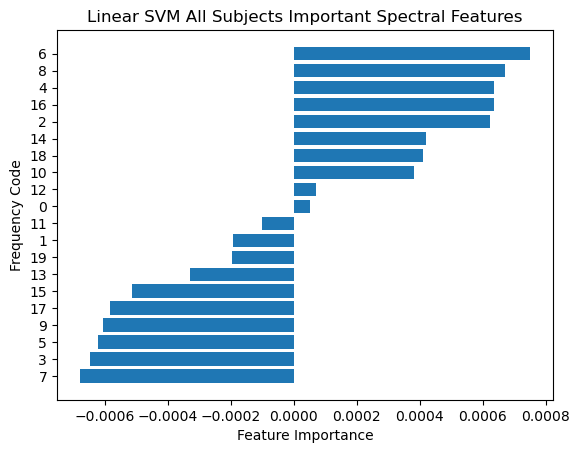

In [832]:
from matplotlib import pyplot as plt

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.ylabel('Frequency Code')
    plt.xlabel('Feature Importance')
    plt.title('Linear SVM All Subjects Important Spectral Features')
    plt.show()

features_names = col_list
f_importances(svc_V1.coef_[0], features_names)

In [ ]:
from sklearn import metrics

#test accuracy on train data
y_pred = svc_V1.predict(X_test)

confusion = metrics.confusion_matrix(Y_test,y_pred)

              precision   recall  f1-score      support
-1             0.529910  1.00000  0.692734  10063.00000
1              0.000000  0.00000  0.000000   8927.00000
accuracy       0.529910  0.52991  0.529910      0.52991
macro avg      0.264955  0.50000  0.346367  18990.00000
weighted avg   0.280805  0.52991  0.367087  18990.00000
Accuracy Score: 0.5299104791995787
ROC AUC Score 0.5


/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

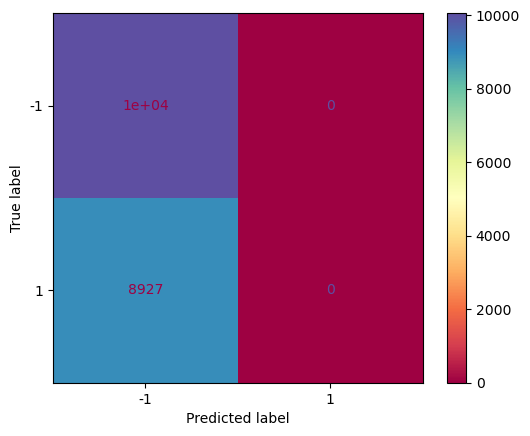

In [846]:
confusion = metrics.confusion_matrix(Y_test,y_pred)
metrics.ConfusionMatrixDisplay.from_predictions(Y_test,y_pred,cmap='Spectral')

#classification_score
print(pd.DataFrame(metrics.classification_report(Y_test,y_pred, labels=np.unique(Y_test),output_dict=True)).T)

#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(Y_test,y_pred))

#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(Y_test,y_pred))

Model 1 with train/test cross validation

In [847]:
from sklearn.model_selection import cross_val_score, ShuffleSplit
svc_V2 = SVC(C=1, kernel='linear')
cv = ShuffleSplit(n_splits=10,train_size = 0.8, test_size=0.2, random_state=42)
scores_full = cross_val_score(svc_V2, X_data, Y_data, cv=cv, n_jobs=1)
print ("Classification score: %s (std. %s)" % (np.mean(scores_full), np.std(scores_full)))


Classification score: 0.5265086887835704 (std. 0.0022740585662599034)


Well, that's terrible. Let's try 1subj at a time...

### Data Wrangling One Subj/Time

In [848]:
svm_epochs_df = pd.read_csv('/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/all_subj_epochs.csv',index_col=0)
subj_ids = ['MS003', 'MS016','MS017','MS019','MS020']
subj_id_codes = [0, 1,2,3,4]

#split power_epochs into subject specific dfs 
df = svm_epochs_df

ms003 = df[df['subj']==0]
ms016 = df[df['subj']==1]
ms017 = df[df['subj']==2]
ms019 = df[df['subj']==3]
ms020 = df[df['subj']==4]


In [849]:
regret_by_subj = pd.DataFrame(columns=subj_ids)
for subj_id in subj_ids:
    regret_by_subj[subj_id] = power_epochs[subj_id]['DecisionOnset'].metadata.regret

MS003

In [850]:
### expanding df for more features (n_freq x n_elec)
ms003_all_features = {}
features_keys = []

subj_id = 'MS003'
freq_features = np.unique(ms003.freq)
roi_features = np.unique(ms003.elec)

for f in freq_features:
    for r in roi_features:
        key = ':'.join(list([str(f),str(r)]))
        features_keys.append(key)
        ms003_all_features[key] = list(ms003.av_pow[(ms003.freq == f) & (ms003.elec == r)])
        #ms003_all_features.append({key:list(ms003.av_pow[(ms003.freq == f) & (ms003.elec == r)])})



    

In [852]:
ms003_inputs_V1 =pd.DataFrame.from_dict(ms003_all_features)
ms003_key_inputs_V1 = features_keys

In [853]:
ms003_key_inputs_V1

['4.0:lacas1',
 '4.0:lacas10',
 '4.0:lacas2',
 '4.0:lacas3',
 '4.0:lacas4',
 '4.0:lacas5',
 '4.0:lacas6',
 '4.0:lacas7',
 '4.0:lacas9',
 '4.0:laglt1',
 '4.0:laglt2',
 '4.0:laglt3',
 '4.0:laglt8',
 '4.0:laglt9',
 '4.0:laimm1',
 '4.0:laimm10',
 '4.0:laimm11',
 '4.0:laimm2',
 '4.0:laimm3',
 '4.0:laimm4',
 '4.0:laimm5',
 '4.0:lhplt1',
 '4.0:lhplt2',
 '4.0:lhplt4',
 '4.0:lhplt6',
 '4.0:lhplt7',
 '4.0:lhplt8',
 '4.0:lhplt9',
 '4.0:lmcms3',
 '4.0:lmcms4',
 '4.0:lmcms8',
 '4.0:lmcms9',
 '4.0:lmolf2',
 '4.0:lmolf3',
 '4.0:lmolf4',
 '4.0:lmolf5',
 '4.0:lmolf7',
 '4.0:lmolf8',
 '4.0:lsifo2',
 '4.0:lsifo7',
 '4.0:racas1',
 '4.0:racas10',
 '4.0:racas11',
 '4.0:racas2',
 '4.0:racas3',
 '4.0:racas4',
 '4.0:racas5',
 '4.0:racas7',
 '4.0:racas8',
 '4.0:raglt1',
 '4.0:raglt2',
 '4.0:raglt3',
 '4.0:raglt6',
 '4.0:raglt7',
 '4.0:raglt9',
 '4.0:raimm1',
 '4.0:raimm10',
 '4.0:raimm11',
 '4.0:raimm13',
 '4.0:raimm2',
 '4.0:raimm3',
 '4.0:raimm4',
 '4.0:raimm5',
 '4.0:raimm6',
 '4.0:raimm9',
 '4.0:rhplt1',
 '

MS016

In [854]:
### expanding df for more features (n_freq x n_elec)
ms016_all_features = {}
features_keys = []

subj_id = 'MS016'
freq_features = np.unique(ms016.freq)
roi_features = np.unique(ms016.elec)

for f in freq_features:
    for r in roi_features:
        key = ':'.join(list([str(f),str(r)]))
        features_keys.append(key)
        ms016_all_features[key] = list(ms016.av_pow[(ms016.freq == f) & (ms016.elec == r)])

In [855]:
ms016_inputs_V1 =pd.DataFrame.from_dict(ms016_all_features)
ms016_key_inputs_V1 = features_keys

MS017

In [856]:
### expanding df for more features (n_freq x n_elec)
ms017_all_features = {}
features_keys = []

subj_id = 'MS017'
freq_features = np.unique(ms017.freq)
roi_features = np.unique(ms017.elec)

for f in freq_features:
    for r in roi_features:
        key = ':'.join(list([str(f),str(r)]))
        features_keys.append(key)
        ms017_all_features[key] = list(ms017.av_pow[(ms017.freq == f) & (ms017.elec == r)])

In [857]:
ms017_inputs_V1 =pd.DataFrame.from_dict(ms017_all_features)
ms017_key_inputs_V1 = features_keys

MS019

In [858]:
### expanding df for more features (n_freq x n_elec)
ms019_all_features = {}
features_keys = []

subj_id = 'MS019'
freq_features = np.unique(ms019.freq)
roi_features = np.unique(ms019.elec)

for f in freq_features:
    for r in roi_features:
        key = ':'.join(list([str(f),str(r)]))
        features_keys.append(key)
        ms019_all_features[key] = list(ms019.av_pow[(ms019.freq == f) & (ms019.elec == r)])

In [859]:
ms019_inputs_V1 =pd.DataFrame.from_dict(ms019_all_features)
ms019_key_inputs_V1 = features_keys

MS020

In [860]:
### expanding df for more features (n_freq x n_elec)
ms020_all_features = {}
features_keys = []

subj_id = 'MS020'
freq_features = np.unique(ms020.freq)
roi_features = np.unique(ms020.elec)

for f in freq_features:
    for r in roi_features:
        key = ':'.join(list([str(f),str(r)]))
        features_keys.append(key)
        ms020_all_features[key] = list(ms020.av_pow[(ms020.freq == f) & (ms020.elec == r)])

In [861]:
ms020_inputs_V1 =pd.DataFrame.from_dict(ms020_all_features)
ms020_key_inputs_V1 = features_keys

In [862]:
#save input dataframes 
ephys_path = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/data/ephys/'

ms003_inputs_V1.to_csv(ephys_path+'ms003_inputs_V1.csv')
ms016_inputs_V1.to_csv(ephys_path+'ms016_inputs_V1.csv')
ms017_inputs_V1.to_csv(ephys_path+'ms017_inputs_V1.csv')
ms019_inputs_V1.to_csv(ephys_path+'ms019_inputs_V1.csv')
ms020_inputs_V1.to_csv(ephys_path+'ms020_inputs_V1.csv')


# SVM Single Subject


MS003

              precision    recall  f1-score    support
-1             0.740741  0.833333  0.784314  24.000000
1              0.777778  0.666667  0.717949  21.000000
accuracy       0.755556  0.755556  0.755556   0.755556
macro avg      0.759259  0.750000  0.751131  45.000000
weighted avg   0.758025  0.755556  0.753343  45.000000
Accuracy Score: 0.7555555555555555
ROC AUC Score 0.75


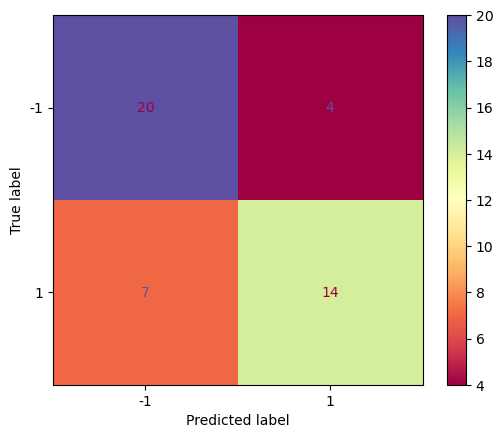

In [863]:
from sklearn import metrics

import sklearn
from sklearn.model_selection import train_test_split

MS003_X_data = ms003_inputs_V1
MS003_X_data = MS003_X_data.fillna(0)
Y_data = regret_by_subj['MS003']
MS003_Y_data = [(-1) if y == 0 else (1) for y in Y_data]


MS003_X_train, MS003_X_test, MS003_Y_train, MS003_Y_test = train_test_split(MS003_X_data,MS003_Y_data,test_size=0.3)


svc_V2 = SVC(C=1, kernel='linear')

# Define an SVM classifier (SVC) with a linear kernel
svc_V2.fit(MS003_X_train, MS003_Y_train)
#test accuracy on train data
MS003_y_pred = svc_V2.predict(MS003_X_test)

confusion_03 = metrics.confusion_matrix(MS003_Y_test,MS003_y_pred)
metrics.ConfusionMatrixDisplay.from_predictions(MS003_Y_test,MS003_y_pred,cmap='Spectral')

#classification_score
print(pd.DataFrame(metrics.classification_report(MS003_Y_test,MS003_y_pred, labels=np.unique(MS003_Y_test),output_dict=True)).T)

#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS003_Y_test,MS003_y_pred))

#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS003_Y_test,MS003_y_pred))

slight improvement.... now for more subjects

MS0016

              precision    recall  f1-score    support
-1             0.565217  0.590909  0.577778  22.000000
1              0.590909  0.565217  0.577778  23.000000
accuracy       0.577778  0.577778  0.577778   0.577778
macro avg      0.578063  0.578063  0.577778  45.000000
weighted avg   0.578349  0.577778  0.577778  45.000000
Accuracy Score: 0.5777777777777777
ROC AUC Score 0.5780632411067192


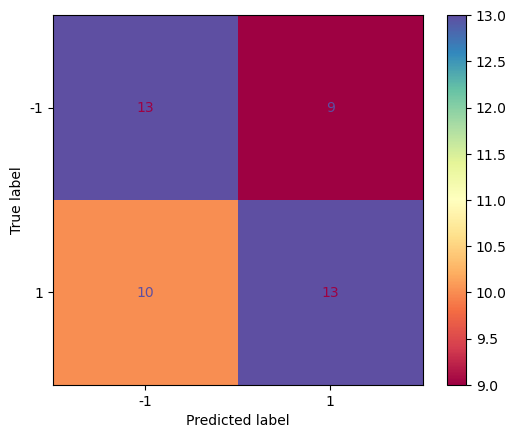

In [867]:
MS016_X_data = ms016_inputs_V1
MS016_X_data = MS016_X_data.fillna(0)
Y_data = regret_by_subj['MS016']
MS016_Y_data = [(-1) if y == 0 else (1) for y in Y_data]


MS016_X_train, MS016_X_test, MS016_Y_train, MS016_Y_test = train_test_split(MS016_X_data,MS016_Y_data,test_size=0.3)


svc_V2 = SVC(C=1, kernel='linear')
# Define an SVM classifier (SVC) with a linear kernel
svc_V2.fit(MS016_X_train, MS016_Y_train)


#test accuracy on train data
MS016_y_pred = svc_V2.predict(MS016_X_test)

confusion_16 = metrics.confusion_matrix(MS016_Y_test,MS016_y_pred)
metrics.ConfusionMatrixDisplay.from_predictions(MS016_Y_test,MS016_y_pred,cmap='Spectral')

#classification_score
print(pd.DataFrame(metrics.classification_report(MS016_Y_test,MS016_y_pred, labels=np.unique(MS016_Y_test),output_dict=True)).T)

#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS016_Y_test,MS016_y_pred))

#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS016_Y_test,MS016_y_pred))

MS017

              precision    recall  f1-score    support
-1             0.714286  0.740741  0.727273  27.000000
1              0.588235  0.555556  0.571429  18.000000
accuracy       0.666667  0.666667  0.666667   0.666667
macro avg      0.651261  0.648148  0.649351  45.000000
weighted avg   0.663866  0.666667  0.664935  45.000000
Accuracy Score: 0.6666666666666666
ROC AUC Score 0.6481481481481481


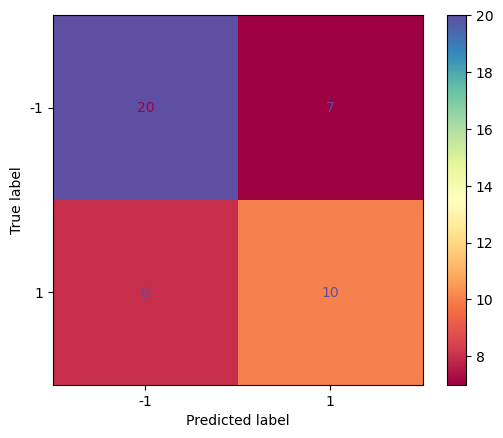

In [870]:
MS017_X_data = ms017_inputs_V1
MS017_X_data = MS017_X_data.fillna(0)
Y_data = regret_by_subj['MS017']
MS017_Y_data = [(-1) if y == 0 else (1) for y in Y_data]


MS017_X_train, MS017_X_test, MS017_Y_train, MS017_Y_test = train_test_split(MS017_X_data,MS017_Y_data,test_size=0.3)


svc_V2 = SVC(C=1, kernel='linear')
# Define an SVM classifier (SVC) with a linear kernel
svc_V2.fit(MS017_X_train, MS017_Y_train)


#test accuracy on train data
MS017_y_pred = svc_V2.predict(MS017_X_test)

confusion_17 = metrics.confusion_matrix(MS017_Y_test,MS017_y_pred)
metrics.ConfusionMatrixDisplay.from_predictions(MS017_Y_test,MS017_y_pred,cmap='Spectral')

#classification_score
print(pd.DataFrame(metrics.classification_report(MS017_Y_test,MS017_y_pred, labels=np.unique(MS017_Y_test),output_dict=True)).T)

#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS017_Y_test,MS017_y_pred))

#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS017_Y_test,MS017_y_pred))

MS019

              precision    recall  f1-score    support
-1             0.555556  0.416667  0.476190  24.000000
1              0.481481  0.619048  0.541667  21.000000
accuracy       0.511111  0.511111  0.511111   0.511111
macro avg      0.518519  0.517857  0.508929  45.000000
weighted avg   0.520988  0.511111  0.506746  45.000000
Accuracy Score: 0.5111111111111111
ROC AUC Score 0.5178571428571428


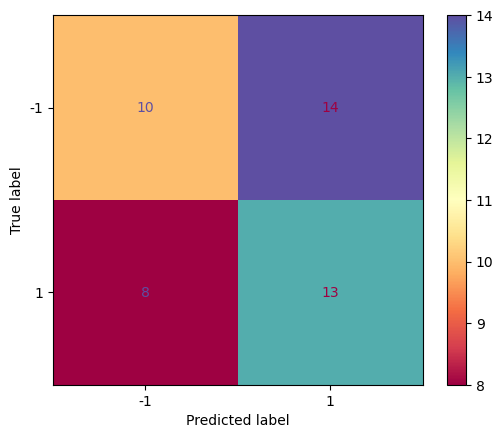

In [878]:
MS019_X_data = ms019_inputs_V1
MS019_X_data = MS019_X_data.fillna(0)
Y_data = regret_by_subj['MS019']
MS019_Y_data = [(-1) if y == 0 else (1) for y in Y_data]


MS019_X_train, MS019_X_test, MS019_Y_train, MS019_Y_test = train_test_split(MS019_X_data,MS019_Y_data,test_size=0.3)


svc_V2 = SVC(C=1, kernel='linear')
# Define an SVM classifier (SVC) with a linear kernel
svc_V2.fit(MS019_X_train, MS019_Y_train)


#test accuracy on train data
MS019_y_pred = svc_V2.predict(MS019_X_test)

confusion_19 = metrics.confusion_matrix(MS019_Y_test,MS019_y_pred)
metrics.ConfusionMatrixDisplay.from_predictions(MS019_Y_test,MS019_y_pred,cmap='Spectral')

#classification_score
print(pd.DataFrame(metrics.classification_report(MS019_Y_test,MS019_y_pred, labels=np.unique(MS019_Y_test),output_dict=True)).T)

#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS019_Y_test,MS019_y_pred))

#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS019_Y_test,MS019_y_pred))

MS020

              precision    recall  f1-score  support
-1             0.761905  0.551724     0.640     29.0
1              0.458333  0.687500     0.550     16.0
accuracy       0.600000  0.600000     0.600      0.6
macro avg      0.610119  0.619612     0.595     45.0
weighted avg   0.653968  0.600000     0.608     45.0
Accuracy Score: 0.6
ROC AUC Score 0.6196120689655172


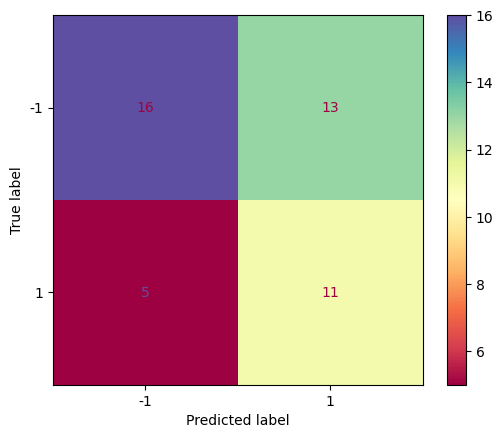

In [884]:
MS020_X_data = ms020_inputs_V1
MS020_X_data = MS020_X_data.fillna(0)
Y_data = regret_by_subj['MS020']
MS020_Y_data = [(-1) if y == 0 else (1) for y in Y_data]


MS020_X_train, MS020_X_test, MS020_Y_train, MS020_Y_test = train_test_split(MS020_X_data,MS020_Y_data,test_size=0.3)


svc_V2 = SVC(C=1, kernel='linear')
# Define an SVM classifier (SVC) with a linear kernel
svc_V2.fit(MS020_X_train, MS020_Y_train)


#test accuracy on train data
MS020_y_pred = svc_V2.predict(MS020_X_test)

confusion_20 = metrics.confusion_matrix(MS020_Y_test,MS020_y_pred)
metrics.ConfusionMatrixDisplay.from_predictions(MS020_Y_test,MS020_y_pred,cmap='Spectral')

#classification_score
print(pd.DataFrame(metrics.classification_report(MS020_Y_test,MS020_y_pred, labels=np.unique(MS020_Y_test),output_dict=True)).T)

#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS020_Y_test,MS020_y_pred))

#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS020_Y_test,MS020_y_pred))

In [885]:
from sklearn.model_selection import cross_val_score

best_score = 0
cv_scores = {}
best_parameter = {}
for C in [0.0001,0.001,0.01,0.1,1,10,100,1000]:
  cv_linear_svm = svm.SVC(kernel = 'linear',C=C)
  scores = cross_val_score(cv_linear_svm,X_train,Y_train,cv=5)
  cv_scores[C]= scores
  score = np.mean(scores)
  if score > best_score:
    best_score = score
    best_parameter={'C':C}

print('The value for C with the highest score is ',best_parameter)
print(cv_scores)

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

X_data = svm_X
Y_data = svm_Y

X_train, X_test, Y_train, Y_test = train_test_split(X_data,Y_data,test_size=0.3)



In [ ]:
svc_V1 = SVC(C=1, kernel='linear')

In [ ]:
# Define an SVM classifier (SVC) with a linear kernel
svc_V1.fit(X_train, Y_train)

SVC(C=1, kernel='linear')

In [ ]:
from sklearn import metrics

#test accuracy on train data
y_pred = svc_V1.predict(X_test)

confusion = metrics.confusion_matrix(Y_test,y_pred)

              precision   recall  f1-score      support
-1             0.529910  1.00000  0.692734  10063.00000
1              0.000000  0.00000  0.000000   8927.00000
accuracy       0.529910  0.52991  0.529910      0.52991
macro avg      0.264955  0.50000  0.346367  18990.00000
weighted avg   0.280805  0.52991  0.367087  18990.00000
Accuracy Score: 0.5299104791995787
ROC AUC Score 0.5


/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

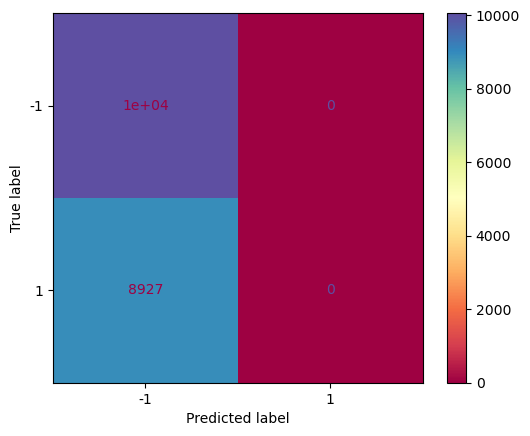

In [ ]:
confusion = metrics.confusion_matrix(Y_test,y_pred)
metrics.ConfusionMatrixDisplay.from_predictions(Y_test,y_pred,cmap='Spectral')

#classification_score
print(pd.DataFrame(metrics.classification_report(Y_test,y_pred, labels=np.unique(Y_test),output_dict=True)).T)

#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(Y_test,y_pred))

#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(Y_test,y_pred))

# SVM Single Subject with Cross Validation of train/test split

In [595]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

svc_V2 = SVC(C=1, kernel='linear')
cv = ShuffleSplit(n_splits=10,train_size = 0.7, test_size=0.3, random_state=42)

scores_full_MS003 = cross_val_score(svc_V2, MS003_X_data,MS003_Y_data, cv=cv, n_jobs=1)
print ("MS003 Classification score: %s (std. %s)" % (np.mean(scores_full_MS003), np.std(scores_full_MS003)))
class_balance_MS003 = sum(np.array(MS003_Y_data) == 1)/150
class_balance_MS003 = max(class_balance_MS003, 1. - class_balance_MS003)
print('MS003 Chance Level: ', class_balance_MS003)

scores_full_MS016 = cross_val_score(svc_V2, MS016_X_data,MS016_Y_data, cv=cv, n_jobs=1)
print ("MS016 Classification score: %s (std. %s)" % (np.mean(scores_full_MS016), np.std(scores_full_MS016)))
class_balance_MS016 = sum(np.array(MS016_Y_data) == 1)/150
class_balance_MS016 = max(class_balance_MS016, 1. - class_balance_MS016)
print('MS016 Chance Level: ', class_balance_MS016)

scores_full_MS017 = cross_val_score(svc_V2, MS017_X_data,MS017_Y_data, cv=cv, n_jobs=1)
print ("MS017 Classification score: %s (std. %s)" % (np.mean(scores_full_MS017), np.std(scores_full_MS017)))
class_balance_MS017 = sum(np.array(MS017_Y_data) == 1)/150
class_balance_MS017 = max(class_balance_MS017, 1. - class_balance_MS017)
print('MS017 Chance Level: ', class_balance_MS017)

scores_full_MS019 = cross_val_score(svc_V2, MS019_X_data,MS019_Y_data, cv=cv, n_jobs=1)
print ("MS019 Classification score: %s (std. %s)" % (np.mean(scores_full_MS019), np.std(scores_full_MS019)))
class_balance_MS019 = sum(np.array(MS019_Y_data) == 1)/150
class_balance_MS019 = max(class_balance_MS019, 1. - class_balance_MS019)
print('MS019 Chance Level: ', class_balance_MS019)

scores_full_MS020 = cross_val_score(svc_V2, MS020_X_data,MS020_Y_data, cv=cv, n_jobs=1)
print ("MS020 Classification score: %s (std. %s)" % (np.mean(scores_full_MS020), np.std(scores_full_MS020)))
class_balance_MS020 = sum(np.array(MS020_Y_data) == 1)/150
class_balance_MS020 = max(class_balance_MS020, 1. - class_balance_MS020)
print('MS020 Chance Level: ', class_balance_MS020)


MS003 Classification score: 0.6799999999999999 (std. 0.07630348761506399)
MS003 Chance Level:  0.5066666666666667
MS016 Classification score: 0.5866666666666666 (std. 0.04268749491621898)
MS016 Chance Level:  0.5066666666666666
MS017 Classification score: 0.6266666666666666 (std. 0.07118052168020873)
MS017 Chance Level:  0.56
MS019 Classification score: 0.5033333333333333 (std. 0.09)
MS019 Chance Level:  0.5066666666666666
MS020 Classification score: 0.4066666666666666 (std. 0.07717224601860151)
MS020 Chance Level:  0.5800000000000001


### hyperparameter tuning via gridsearchCV

In [596]:
from sklearn.model_selection import GridSearchCV

#hyperparameter tuning
# defining parameter range 
param_grid = {'C': [0.0001,0.001,0.01,0.1, 1, 10, 100],  
              'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],  
              'gamma':['scale', 'auto'],
              'kernel': ['linear']}
   
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1,return_train_score=True) 

MS003

In [602]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

grid_MS003 = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1,return_train_score=True) 
MS003_X_train, MS003_X_test, MS003_Y_train, MS003_Y_test = train_test_split(MS003_X_data,MS003_Y_data,test_size=0.3)

# fitting the model for grid search 
grid_MS003.fit(MS003_X_train, MS003_Y_train) 
 

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 2/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.536, test=0.524) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.536, test=0.524) total time=   0.0s
[CV 1/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.536, test=0.524) total time=   0.0s
[CV 5/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.524, test=0.571) total time=   0.0s
[CV 1/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.536, test=0.524) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.536, test=0.524) total time=   0.0s
[CV 2/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.536, test=0.524) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.536, test=0.524) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.536, test=0.524) total time=   0.0s
[CV 5/5] END C=0

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto'], 'kernel': ['linear']},
             return_train_score=True, verbose=3)

In [603]:
# print best parameter after tuning 
print(grid_MS003.best_params_) 
grid_MS003_predictions = grid_MS003.predict(MS003_X_test) 
   
# print classification report 
print(classification_report(MS003_Y_test, grid_MS003_predictions))


{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

          -1       0.84      0.64      0.73        25
           1       0.65      0.85      0.74        20

    accuracy                           0.73        45
   macro avg       0.75      0.74      0.73        45
weighted avg       0.76      0.73      0.73        45



In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(MS003_Y_test, grid_MS003_predictions,cmap='Spectral')

#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS003_Y_test, grid_MS003_predictions))

#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS003_Y_test, grid_MS003_predictions))

MS016

In [604]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

grid_MS016 = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1,return_train_score=True) 
MS016_X_train, MS016_X_test, MS016_Y_train, MS016_Y_test = train_test_split(MS016_X_data,MS016_Y_data,test_size=0.3)

# fitting the model for grid search 
grid_MS016.fit(MS016_X_train, MS016_Y_train) 


Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 2/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.560, test=0.524) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.548, test=0.571) total time=   0.0s
[CV 1/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.560, test=0.524) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.548, test=0.571) total time=   0.0s
[CV 1/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.560, test=0.524) total time=   0.0s
[CV 2/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.560, test=0.524) total time=   0.0s
[CV 5/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.548, test=0.571) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.548, test=0.571) total time=   0.1s
[CV 4/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.548, test=0.571) total time=   0.0s
[CV 2/5] END C=0

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto'], 'kernel': ['linear']},
             return_train_score=True, verbose=3)

In [605]:
# print best parameter after tuning 
print(grid_MS016.best_params_) 
grid_MS016_predictions = grid_MS016.predict(MS016_X_test) 
   
# print classification report 
print(classification_report(MS016_Y_test, grid_MS016_predictions))

{'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

          -1       0.42      0.72      0.53        18
           1       0.64      0.33      0.44        27

    accuracy                           0.49        45
   macro avg       0.53      0.53      0.48        45
weighted avg       0.55      0.49      0.48        45



In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(MS016_Y_test, grid_MS016_predictions,cmap='Spectral')

#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS016_Y_test, grid_MS016_predictions))

#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS016_Y_test, grid_MS016_predictions))

MS017

In [606]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

grid_MS017 = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1,return_train_score=True) 
MS017_X_train, MS017_X_test, MS017_Y_train, MS017_Y_test = train_test_split(MS017_X_data,MS017_Y_data,test_size=0.3)

# fitting the model for grid search 
grid_MS017.fit(MS017_X_train, MS017_Y_train) 

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.571, test=0.571) total time=   0.0s
[CV 2/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.571, test=0.571) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.571, test=0.571) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.571, test=0.571) total time=   0.0s
[CV 5/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.571, test=0.571) total time=   0.0s
[CV 2/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.571, test=0.571) total time=   0.0s
[CV 1/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.571, test=0.571) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.571, test=0.571) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.571, test=0.571) total time=   0.0s
[CV 5/5] END C=0

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto'], 'kernel': ['linear']},
             return_train_score=True, verbose=3)

In [607]:
# print best parameter after tuning 
print(grid_MS017.best_params_) 
grid_MS017_predictions = grid_MS017.predict(MS017_X_test) 
   
# print classification report 
print(classification_report(MS017_Y_test, grid_MS017_predictions))

{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

          -1       0.58      0.62      0.60        24
           1       0.53      0.48      0.50        21

    accuracy                           0.56        45
   macro avg       0.55      0.55      0.55        45
weighted avg       0.55      0.56      0.55        45



In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(MS017_Y_test, grid_MS017_predictions,cmap='Spectral')

#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS017_Y_test, grid_MS017_predictions))

#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS017_Y_test, grid_MS017_predictions))

MS019

In [608]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

grid_MS019 = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1,return_train_score=True) 
MS019_X_train, MS019_X_test, MS019_Y_train, MS019_Y_test = train_test_split(MS019_X_data,MS019_Y_data,test_size=0.3)

# fitting the model for grid search 
grid_MS019.fit(MS019_X_train, MS019_Y_train) 

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.512, test=0.476) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.726, test=0.333) total time=   0.0s
[CV 5/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.786, test=0.524) total time=   0.0s
[CV 1/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.512, test=0.476) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.762, test=0.524) total time=   0.0s[CV 2/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.512, test=0.476) total time=   0.0s

[CV 2/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.512, test=0.476) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.726, test=0.333) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.762, test=0.524) total time=   0.0s
[CV 5/5] END C=0

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto'], 'kernel': ['linear']},
             return_train_score=True, verbose=3)

In [609]:
# print best parameter after tuning 
print(grid_MS019.best_params_) 
grid_MS019_predictions = grid_MS019.predict(MS019_X_test) 
   
# print classification report 
print(classification_report(MS019_Y_test, grid_MS019_predictions))

{'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

          -1       0.54      0.54      0.54        24
           1       0.48      0.48      0.48        21

    accuracy                           0.51        45
   macro avg       0.51      0.51      0.51        45
weighted avg       0.51      0.51      0.51        45



MS020

In [610]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

grid_MS020 = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=-1,return_train_score=True) 
MS020_X_train, MS020_X_test, MS020_Y_train, MS020_Y_test = train_test_split(MS020_X_data,MS020_Y_data,test_size=0.3)

# fitting the model for grid search 
grid_MS020.fit(MS020_X_train, MS020_Y_train) 

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.631, test=0.619) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.631, test=0.619) total time=   0.0s
[CV 4/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.631, test=0.619) total time=   0.0s
[CV 2/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.631, test=0.619) total time=   0.0s
[CV 3/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.631, test=0.619) total time=   0.0s
[CV 2/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.631, test=0.619) total time=   0.0s
[CV 5/5] END C=0.0001, gamma=scale, kernel=linear;, score=(train=0.619, test=0.667) total time=   0.0s
[CV 1/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.631, test=0.619) total time=   0.0s
[CV 5/5] END C=0.0001, gamma=auto, kernel=linear;, score=(train=0.619, test=0.667) total time=   0.0s
[CV 2/5] END C=0

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto'], 'kernel': ['linear']},
             return_train_score=True, verbose=3)

In [611]:
# print best parameter after tuning 
print(grid_MS020.best_params_) 
grid_MS020_predictions = grid_MS020.predict(MS020_X_test) 
   
# print classification report 
print(classification_report(MS020_Y_test, grid_MS020_predictions))

{'C': 0.0001, 'gamma': 'scale', 'kernel': 'linear'}
              precision    recall  f1-score   support

          -1       0.47      1.00      0.64        21
           1       0.00      0.00      0.00        24

    accuracy                           0.47        45
   macro avg       0.23      0.50      0.32        45
weighted avg       0.22      0.47      0.30        45



/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [613]:
from sklearn.model_selection import cross_val_score, ShuffleSplit

cv = ShuffleSplit(n_splits=10,train_size = 0.7, test_size=0.3, random_state=42)


ms003_svc_V3 = SVC(C=0.01, kernel='linear')
scores_full_MS003 = cross_val_score(ms003_svc_V3, MS003_X_data,MS003_Y_data, cv=cv, n_jobs=1)
print ("MS003 Classification score: %s (std. %s)" % (np.mean(scores_full_MS003), np.std(scores_full_MS003)))

ms016_svc_V3 = SVC(C=0.001, kernel='linear')
scores_full_MS016 = cross_val_score(ms016_svc_V3, MS016_X_data,MS016_Y_data, cv=cv, n_jobs=1)
print ("MS016 Classification score: %s (std. %s)" % (np.mean(scores_full_MS016), np.std(scores_full_MS016)))

ms017_svc_V3 = SVC(C=0.01, kernel='linear')
scores_full_MS017 = cross_val_score(ms017_svc_V3, MS017_X_data,MS017_Y_data, cv=cv, n_jobs=1)
print ("MS017 Classification score: %s (std. %s)" % (np.mean(scores_full_MS017), np.std(scores_full_MS017)))

ms019_svc_V3 = SVC(C=0.01, kernel='linear')
scores_full_MS019 = cross_val_score(ms019_svc_V3, MS019_X_data,MS019_Y_data, cv=cv, n_jobs=1)
print ("MS019 Classification score: %s (std. %s)" % (np.mean(scores_full_MS019), np.std(scores_full_MS019)))

ms020_svc_V3 = SVC(C=0.0001, kernel='linear')
scores_full_MS020 = cross_val_score(ms020_svc_V3, MS020_X_data,MS020_Y_data, cv=cv, n_jobs=1)
print ("MS020 Classification score: %s (std. %s)" % (np.mean(scores_full_MS020), np.std(scores_full_MS020)))

MS003 Classification score: 0.6799999999999999 (std. 0.07630348761506399)
MS016 Classification score: 0.5933333333333333 (std. 0.07423685817106694)
MS017 Classification score: 0.6333333333333333 (std. 0.07149203529842406)
MS019 Classification score: 0.5133333333333333 (std. 0.0581186525805423)
MS020 Classification score: 0.51 (std. 0.08034647195462633)


In [622]:

MS003_X_train, MS003_X_test, MS003_Y_train, MS003_Y_test = train_test_split(MS003_X_data,MS003_Y_data,test_size=0.3)
MS016_X_train, MS016_X_test, MS016_Y_train, MS016_Y_test = train_test_split(MS016_X_data,MS016_Y_data,test_size=0.3)
MS017_X_train, MS017_X_test, MS017_Y_train, MS017_Y_test = train_test_split(MS017_X_data,MS017_Y_data,test_size=0.3)
MS019_X_train, MS019_X_test, MS019_Y_train, MS019_Y_test = train_test_split(MS019_X_data,MS019_Y_data,test_size=0.3)
MS020_X_train, MS020_X_test, MS020_Y_train, MS020_Y_test = train_test_split(MS020_X_data,MS020_Y_data,test_size=0.3)

ms003_svc_V3 = SVC(C=0.001, kernel='linear')

ms016_svc_V3 = SVC(C=0.001, kernel='linear')

ms017_svc_V3 = SVC(C=0.001, kernel='linear')

ms019_svc_V3 = SVC(C=0.001, kernel='linear')

ms020_svc_V3 = SVC(C=0.001, kernel='linear')



# Define an SVM classifier (SVC) with a linear kernel
ms003_svc_V3.fit(MS003_X_train, MS003_Y_train)
ms016_svc_V3.fit(MS016_X_train, MS016_Y_train)
ms017_svc_V3.fit(MS017_X_train, MS017_Y_train)
ms019_svc_V3.fit(MS019_X_train, MS019_Y_train)
ms020_svc_V3.fit(MS020_X_train, MS020_Y_train)


#test accuracy on train data
MS003_y_pred = ms003_svc_V3.predict(MS003_X_test)
MS016_y_pred = ms016_svc_V3.predict(MS016_X_test)
MS017_y_pred = ms017_svc_V3.predict(MS017_X_test)
MS019_y_pred = ms019_svc_V3.predict(MS019_X_test)
MS020_y_pred = ms020_svc_V3.predict(MS020_X_test)


              precision    recall  f1-score    support
-1             0.636364  0.280000  0.388889  25.000000
1              0.470588  0.800000  0.592593  20.000000
accuracy       0.511111  0.511111  0.511111   0.511111
macro avg      0.553476  0.540000  0.490741  45.000000
weighted avg   0.562686  0.511111  0.479424  45.000000
Accuracy Score: 0.5111111111111111
ROC AUC Score 0.54


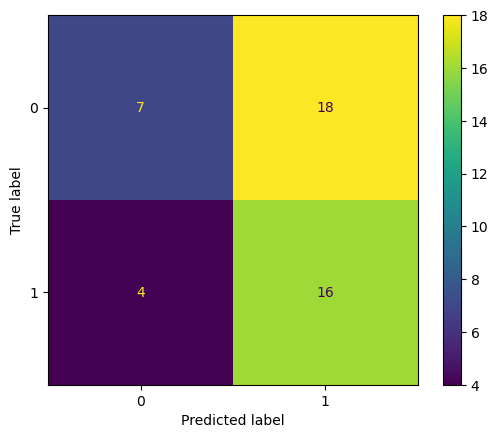

In [623]:
confusion_03 = metrics.confusion_matrix(MS003_Y_test,MS003_y_pred)
metrics.ConfusionMatrixDisplay(confusion_03).plot()
#classification_score
print(pd.DataFrame(metrics.classification_report(MS003_Y_test,MS003_y_pred, labels=np.unique(MS003_Y_test),output_dict=True)).T)
#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS003_Y_test,MS003_y_pred))
#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS003_Y_test,MS003_y_pred))

              precision    recall  f1-score    support
-1             0.583333  0.777778  0.666667  18.000000
1              0.809524  0.629630  0.708333  27.000000
accuracy       0.688889  0.688889  0.688889   0.688889
macro avg      0.696429  0.703704  0.687500  45.000000
weighted avg   0.719048  0.688889  0.691667  45.000000
Accuracy Score: 0.6888888888888889
ROC AUC Score 0.7037037037037038


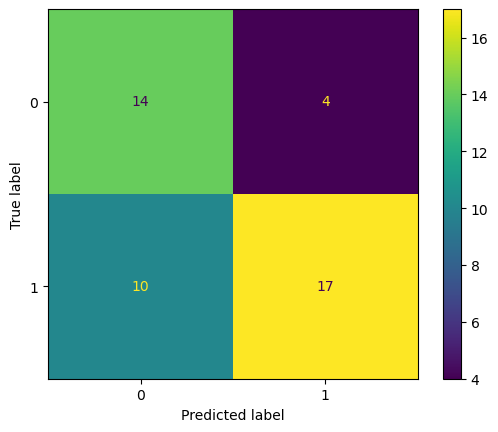

In [618]:
confusion_16 = metrics.confusion_matrix(MS016_Y_test,MS016_y_pred)
metrics.ConfusionMatrixDisplay(confusion_16).plot()
#classification_score
print(pd.DataFrame(metrics.classification_report(MS016_Y_test,MS016_y_pred, labels=np.unique(MS016_Y_test),output_dict=True)).T)
#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS016_Y_test,MS016_y_pred))
#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS016_Y_test,MS016_y_pred))

              precision    recall  f1-score    support
-1             0.568182  1.000000  0.724638  25.000000
1              1.000000  0.050000  0.095238  20.000000
accuracy       0.577778  0.577778  0.577778   0.577778
macro avg      0.784091  0.525000  0.409938  45.000000
weighted avg   0.760101  0.577778  0.444905  45.000000
Accuracy Score: 0.5777777777777777
ROC AUC Score 0.525


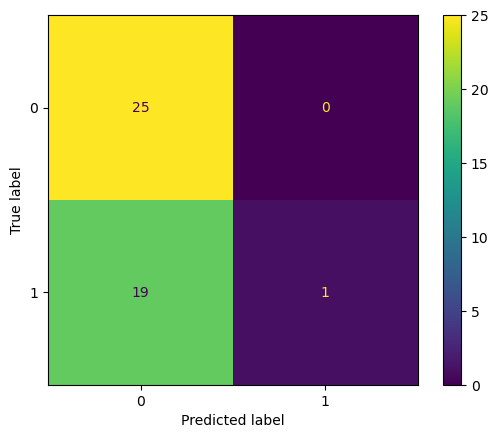

In [624]:
confusion_17 = metrics.confusion_matrix(MS017_Y_test,MS017_y_pred)
metrics.ConfusionMatrixDisplay(confusion_17).plot()
#classification_score
print(pd.DataFrame(metrics.classification_report(MS017_Y_test,MS017_y_pred, labels=np.unique(MS017_Y_test),output_dict=True)).T)
#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS017_Y_test,MS017_y_pred))
#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS017_Y_test,MS017_y_pred))

              precision    recall  f1-score    support
-1             0.458333  0.458333  0.458333  24.000000
1              0.380952  0.380952  0.380952  21.000000
accuracy       0.422222  0.422222  0.422222   0.422222
macro avg      0.419643  0.419643  0.419643  45.000000
weighted avg   0.422222  0.422222  0.422222  45.000000
Accuracy Score: 0.4222222222222222
ROC AUC Score 0.41964285714285715


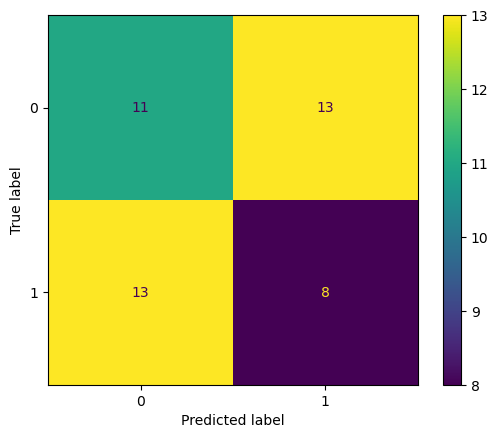

In [619]:
confusion_19 = metrics.confusion_matrix(MS019_Y_test,MS019_y_pred)
metrics.ConfusionMatrixDisplay(confusion_19).plot()
#classification_score
print(pd.DataFrame(metrics.classification_report(MS019_Y_test,MS019_y_pred, labels=np.unique(MS019_Y_test),output_dict=True)).T)
#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS019_Y_test,MS019_y_pred))
#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS019_Y_test,MS019_y_pred))

              precision    recall  f1-score    support
-1             0.533333  1.000000  0.695652  24.000000
1              0.000000  0.000000  0.000000  21.000000
accuracy       0.533333  0.533333  0.533333   0.533333
macro avg      0.266667  0.500000  0.347826  45.000000
weighted avg   0.284444  0.533333  0.371014  45.000000
Accuracy Score: 0.5333333333333333
ROC AUC Score 0.5


/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

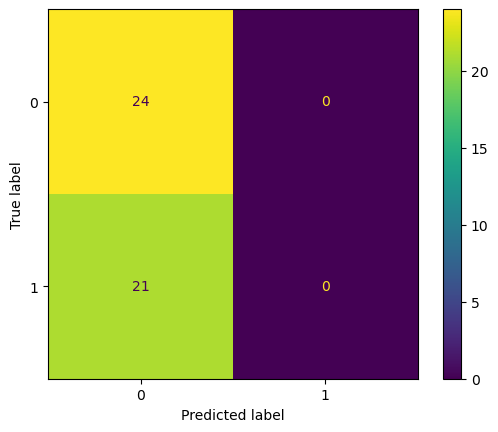

In [625]:
confusion_20 = metrics.confusion_matrix(MS020_Y_test,MS020_y_pred)
metrics.ConfusionMatrixDisplay(confusion_20).plot()
#classification_score
print(pd.DataFrame(metrics.classification_report(MS020_Y_test,MS020_y_pred, labels=np.unique(MS020_Y_test),output_dict=True)).T)
#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS020_Y_test,MS020_y_pred))
#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS020_Y_test,MS020_y_pred))

In [637]:
ms003_feat = ms003_key_inputs_V1
ms016_feat = ms016_key_inputs_V1
ms017_feat = ms017_key_inputs_V1
ms019_feat = ms019_key_inputs_V1
ms020_feat = ms020_key_inputs_V1

In [671]:
from matplotlib import pyplot as plt

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    imp_pos = imp[0:10]
    imp_neg = imp[-11:-1]
    names_pos = names[0:10]
    names_neg = names[-11:-1]
    return imp_pos, names_pos, imp_neg, names_neg



In [672]:
ms003_pos_coeff,ms003_pos_feat, ms003_neg_coeff, ms003_neg_feat = f_importances(ms003_svc_V3.coef_[0], ms003_feat)
ms016_pos_coeff,ms016_pos_feat, ms016_neg_coeff, ms016_neg_feat = f_importances(ms016_svc_V3.coef_[0], ms016_feat)
ms017_pos_coeff,ms017_pos_feat, ms017_neg_coeff, ms017_neg_feat = f_importances(ms017_svc_V3.coef_[0], ms017_feat)
ms019_pos_coeff,ms019_pos_feat, ms019_neg_coeff, ms019_neg_feat = f_importances(ms019_svc_V3.coef_[0], ms019_feat)
ms020_pos_coeff,ms020_pos_feat, ms020_neg_coeff, ms020_neg_feat = f_importances(ms020_svc_V3.coef_[0], ms020_feat)

In [673]:
imp_features_dict = {}
imp_features_dict['MS003'] = ms003_pos_feat, ms003_neg_feat
imp_features_dict['MS016'] = ms016_pos_feat, ms016_neg_feat
imp_features_dict['MS017'] = ms017_pos_feat, ms017_neg_feat
imp_features_dict['MS019'] = ms019_pos_feat, ms019_neg_feat
imp_features_dict['MS020'] = ms020_pos_feat, ms020_neg_feat


In [688]:
subj_ids = ['MS003', 'MS016','MS017','MS019','MS020']
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/Classes/ML/final_proj/'
anat_path = base_dir + '/data/anat/'


imp_roi_pos = []
imp_roi_neg = []
imp_elec_pos = []
imp_elec_neg = []
imp_freq_pos = []
imp_freq_neg = []


for ix,subj_id in enumerate(subj_ids):
    elec_file = anat_path + subj_id + '_labels.csv'
    elec_data = pd.read_csv(elec_file)
    elec_data = elec_data.rename(columns={'NMMlabel':'label'})


    pos_features = imp_features_dict[subj_id][0]
    neg_features = imp_features_dict[subj_id][1]

    for i in range(len(pos_features)):
        pos_freq = pos_features[i].split(':')[0]
        neg_freq = neg_features[i].split(':')[0]

        pos_elec = pos_features[i].split(':')[1]
        neg_elec = neg_features[i].split(':')[1]
        
        imp_freq_pos.append(pos_freq)
        imp_freq_neg.append(neg_freq)
        imp_elec_pos.append(pos_elec)
        imp_elec_neg.append(neg_elec)

        yba_pos = elec_data.YBA_1[np.where(elec_data.label.str.lower()==pos_elec)[0][0]].lower()
        yba_neg = elec_data.YBA_1[np.where(elec_data.label.str.lower()==neg_elec)[0][0]].lower()

        if yba_pos == 'unknown':
            yba_pos = elec_data['Manual Examination'][np.where(elec_data.label.str.lower()==pos_elec)[0][0]].lower()
        if yba_neg == 'unknown':
            yba_neg = elec_data['Manual Examination'][np.where(elec_data.label.str.lower()==neg_elec)[0][0]].lower()
        
        imp_roi_pos.append(yba_pos)
        imp_roi_neg.append(yba_neg)
        


In [742]:
rois = ['motor','orbital','cingulate','insular','amygdala','hippocampus']

region_pos = []
region_neg = []

for region in rois:
    for r in range(len(imp_roi_pos)):
        rpos = np.intersect1d(imp_roi_pos[r].split(),rois)
        rneg = np.intersect1d(imp_roi_neg[r].split(),rois)
        if any(rpos):
            region_pos.append(rpos[0])
        if any(rneg):
            region_neg.append(rneg[0])



<AxesSubplot: title={'center': 'ROIs Important for Positive Class'}>

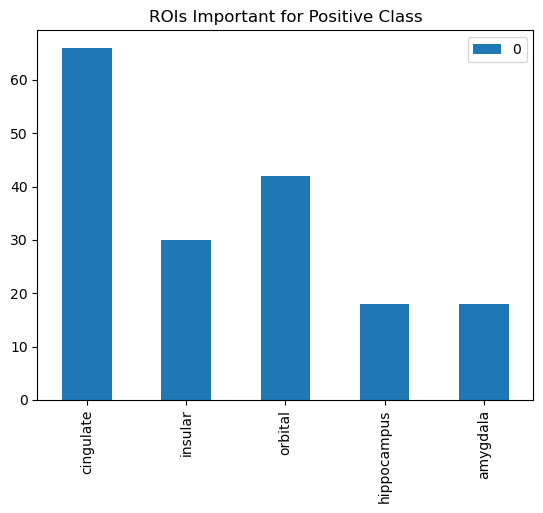

In [745]:
import pandas as pd
from collections import Counter
region_pos_counts = Counter(region_pos)
df = pd.DataFrame.from_dict(region_pos_counts, orient='index')
df.plot(kind='bar',title='ROIs Important for Positive Class')

<AxesSubplot: title={'center': 'ROIs Important for Negative Class'}>

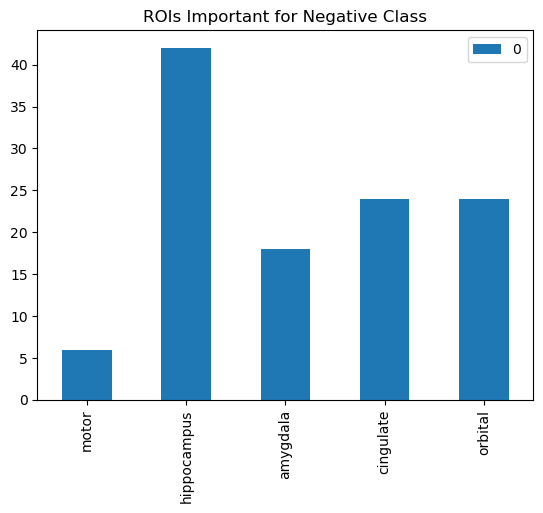

In [746]:
import pandas as pd
from collections import Counter
region_neg_counts = Counter(region_neg)
df = pd.DataFrame.from_dict(region_neg_counts, orient='index')
df.plot(kind='bar',title='ROIs Important for Negative Class')

<AxesSubplot: title={'center': 'Freq Bands Important for Positive Class'}>

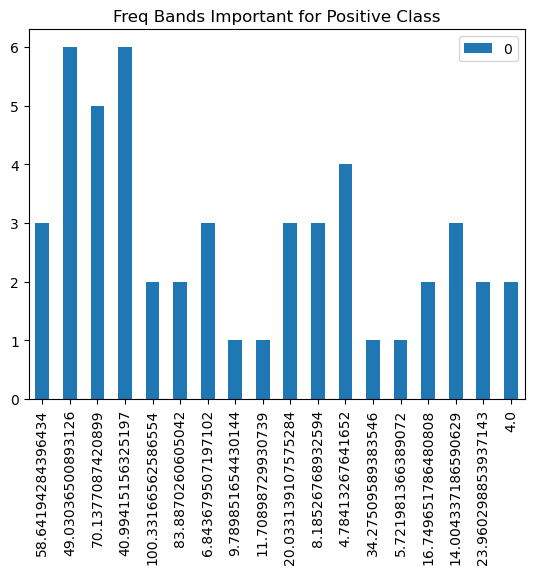

In [747]:
import pandas as pd
from collections import Counter
imp_freq_pos_counts = Counter(imp_freq_pos)
df = pd.DataFrame.from_dict(imp_freq_pos_counts, orient='index')
df.plot(kind='bar',title='Freq Bands Important for Positive Class')

<AxesSubplot: title={'center': 'Freq Bands Important for Negative Class'}>

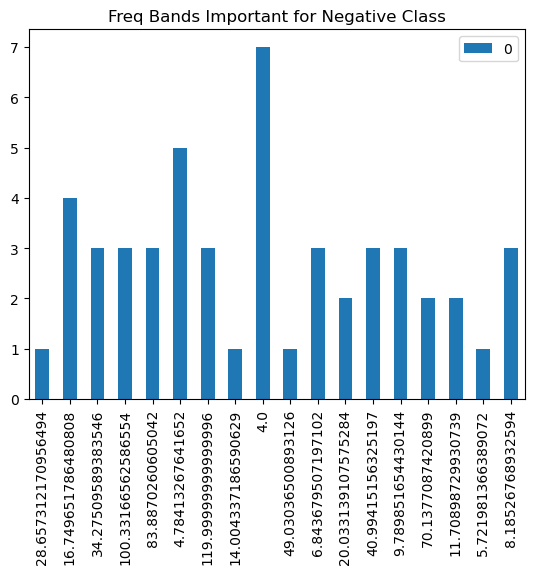

In [748]:
import pandas as pd
from collections import Counter
imp_freq_neg_counts = Counter(imp_freq_neg)
df = pd.DataFrame.from_dict(imp_freq_neg_counts, orient='index')
df.plot(kind='bar',title='Freq Bands Important for Negative Class')

Now with feature selection:
https://h2o.ai/wiki/feature-selection/#:~:text=In%20the%20machine%20learning%20process,why%20feature%20selection%20is%20important.
https://scikit-learn.org/stable/modules/feature_selection.html
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV
https://vitalflux.com/ridge-classification-concepts-python-examples/#:~:text=In%20machine%20learning%2C%20ridge%20classification,model%20coefficients%20to%20prevent%20overfitting

USE EXTRACTED FEATURES ONLY FOR MODELS!! THEN USE ROC CURVE

In [ ]:
def reduce_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    imp_pos = imp[0:10]
    imp_neg = imp[-11:-1]
    imp_all = imp_pos + imp_neg
    names_pos = names[0:10]
    names_neg = names[-11:-1]
    names_all = names_pos + names_neg
    return imp_all, names_all

In [ ]:
ms003_coeff, ms003_feat = f_importances(ms003_svc_V3.coef_[0], ms003_feat)
ms016_coeff, ms016_feat = f_importances(ms016_svc_V3.coef_[0], ms016_feat)
ms017_coeff, ms017_feat = f_importances(ms017_svc_V3.coef_[0], ms017_feat)
ms019_coeff, ms019_feat = f_importances(ms019_svc_V3.coef_[0], ms019_feat)
ms020_coeff, ms020_feat = f_importances(ms020_svc_V3.coef_[0], ms020_feat)

In [ ]:
MS003_X_reduc = MS003_X_data[ms003_feat]

In [ ]:
important_features_dict


MS003_X_reduc = MS003_X_data[]
MS016_X_reduc = MS003_X_data[]
MS017_X_reduc = MS003_X_data[]
MS019_X_reduc = MS003_X_data[]
MS020_X_reduc = MS003_X_data[]



MS003_X_train, MS003_X_test, MS003_Y_train, MS003_Y_test = train_test_split(MS003_X_reduc,MS003_Y_data,test_size=0.3)
MS016_X_train, MS016_X_test, MS016_Y_train, MS016_Y_test = train_test_split(MS016_X_reduc,MS016_Y_data,test_size=0.3)
MS017_X_train, MS017_X_test, MS017_Y_train, MS017_Y_test = train_test_split(MS017_X_reduc,MS017_Y_data,test_size=0.3)
MS019_X_train, MS019_X_test, MS019_Y_train, MS019_Y_test = train_test_split(MS019_X_reduc,MS019_Y_data,test_size=0.3)
MS020_X_train, MS020_X_test, MS020_Y_train, MS020_Y_test = train_test_split(MS020_X_reduc,MS020_Y_data,test_size=0.3)

ms003_svc_V4 = SVC(C=0.001, kernel='linear')

ms016_svc_V4 = SVC(C=0.001, kernel='linear')

ms017_svc_V4 = SVC(C=0.001, kernel='linear')

ms019_svc_V4 = SVC(C=0.001, kernel='linear')

ms020_svc_V4 = SVC(C=0.001, kernel='linear')



# Define an SVM classifier (SVC) with a linear kernel
ms003_svc_V4.fit(MS003_X_reduc, MS003_Y_train)
ms016_svc_V4.fit(MS016_X_reduc, MS016_Y_train)
ms017_svc_V4.fit(MS017_X_reduc, MS017_Y_train)
ms019_svc_V4.fit(MS019_X_reduc, MS019_Y_train)
ms020_svc_V4.fit(MS020_X_reduc, MS020_Y_train)


#test accuracy on train data
MS003_y_pred = ms003_svc_V4.predict(MS003_X_test)
MS016_y_pred = ms016_svc_V4.predict(MS016_X_test)
MS017_y_pred = ms017_svc_V4.predict(MS017_X_test)
MS019_y_pred = ms019_svc_V4.predict(MS019_X_test)
MS020_y_pred = ms020_svc_V4.predict(MS020_X_test)


In [ ]:

confusion_03 = metrics.confusion_matrix(MS003_Y_test,MS003_y_pred)
metrics.ConfusionMatrixDisplay(confusion_03).plot()
#classification_score
print(pd.DataFrame(metrics.classification_report(MS003_Y_test,MS003_y_pred, labels=np.unique(MS003_Y_test),output_dict=True)).T)
#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS003_Y_test,MS003_y_pred))
#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS003_Y_test,MS003_y_pred))

In [ ]:
confusion_16 = metrics.confusion_matrix(MS016_Y_test,MS016_y_pred)
metrics.ConfusionMatrixDisplay(confusion_16).plot()
#classification_score
print(pd.DataFrame(metrics.classification_report(MS016_Y_test,MS016_y_pred, labels=np.unique(MS016_Y_test),output_dict=True)).T)
#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS016_Y_test,MS016_y_pred))
#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS016_Y_test,MS016_y_pred))

In [ ]:
confusion_17 = metrics.confusion_matrix(MS017_Y_test,MS017_y_pred)
metrics.ConfusionMatrixDisplay(confusion_17).plot()
#classification_score
print(pd.DataFrame(metrics.classification_report(MS017_Y_test,MS017_y_pred, labels=np.unique(MS017_Y_test),output_dict=True)).T)
#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS017_Y_test,MS017_y_pred))
#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS017_Y_test,MS017_y_pred))

In [ ]:
confusion_19 = metrics.confusion_matrix(MS019_Y_test,MS019_y_pred)
metrics.ConfusionMatrixDisplay(confusion_19).plot()
#classification_score
print(pd.DataFrame(metrics.classification_report(MS019_Y_test,MS019_y_pred, labels=np.unique(MS019_Y_test),output_dict=True)).T)
#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS019_Y_test,MS019_y_pred))
#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS019_Y_test,MS019_y_pred))

In [ ]:
confusion_20 = metrics.confusion_matrix(MS020_Y_test,MS020_y_pred)
metrics.ConfusionMatrixDisplay(confusion_20).plot()
#classification_score
print(pd.DataFrame(metrics.classification_report(MS020_Y_test,MS020_y_pred, labels=np.unique(MS020_Y_test),output_dict=True)).T)
#accuracy_score
print('Accuracy Score:', metrics.accuracy_score(MS020_Y_test,MS020_y_pred))
#roc_auc_score
print('ROC AUC Score',metrics.roc_auc_score(MS020_Y_test,MS020_y_pred))

# Random Forest Classification:

In [753]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, SelectPercentile
from sklearn.pipeline import Pipeline



clf = Pipeline([
    ('feature_selection', SelectPercentile(f_classif, percentile=5)),
    ('classification', RandomForestClassifier())
])

# specify parameters and distributions to sample from
param_dist = {"classification__n_estimators": [10, 100, 500, 1000],
              "classification__max_depth": [3, None],
              "classification__bootstrap": [True, False],
              "classification__criterion": ["gini", "entropy",'log_loss']}


In [ ]:
MS003_X_train, MS003_X_test, MS003_Y_train, MS003_Y_test = train_test_split(MS003_X_data,MS003_Y_data,test_size=0.3)
MS016_X_train, MS016_X_test, MS016_Y_train, MS016_Y_test = train_test_split(MS016_X_data,MS016_Y_data,test_size=0.3)
MS017_X_train, MS017_X_test, MS017_Y_train, MS017_Y_test = train_test_split(MS017_X_data,MS017_Y_data,test_size=0.3)
MS019_X_train, MS019_X_test, MS019_Y_train, MS019_Y_test = train_test_split(MS019_X_data,MS019_Y_data,test_size=0.3)
MS020_X_train, MS020_X_test, MS020_Y_train, MS020_Y_test = train_test_split(MS020_X_data,MS020_Y_data,test_size=0.3)

In [754]:
# run randomized search
n_iter_search = 100
rs_indep_test = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search, 
                                   cv=10, 
                                   scoring='roc_auc')
rs_indep_test.fit(MS003_X_train, MS003_Y_train)
print('Best 10-fold CV AUC score:', rs_indep_test.best_score_)

/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best 10-fold CV AUC score: 0.8386666666666667


In [756]:
ms003_test_score = rs_indep_test.score(MS003_X_test, MS003_Y_test)
print('MS003 Test AUC score:', ms003_test_score)

MS003 Test AUC score: 0.7


In [757]:
# run randomized search
n_iter_search = 100
rs_indep_test = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search, 
                                   cv=10, 
                                   scoring='roc_auc')
rs_indep_test.fit(MS016_X_train, MS016_Y_train)
print('MS016 Best 10-fold CV AUC score:', rs_indep_test.best_score_)

/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MS016 Best 10-fold CV AUC score: 0.4923333333333333


In [758]:
ms016_test_score = rs_indep_test.score(MS016_X_test, MS016_Y_test)
print('MS016 Test AUC score:', ms016_test_score)

MS016 Test AUC score: 0.552


In [ ]:
rs_indep_test.best_params_

In [759]:
# run randomized search
n_iter_search = 100
rs_indep_test = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search, 
                                   cv=10, 
                                   scoring='roc_auc')
rs_indep_test.fit(MS017_X_train, MS017_Y_train)
print('MS017 est 10-fold CV AUC score:', rs_indep_test.best_score_)

/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MS017 est 10-fold CV AUC score: 0.6676666666666666


In [760]:
ms017_test_score = rs_indep_test.score(MS017_X_test, MS017_Y_test)
print('MS017 Test AUC score:', ms017_test_score)

MS017 Test AUC score: 0.5409999999999999


In [ ]:
rs_indep_test.best_params_

In [761]:
# run randomized search
n_iter_search = 100
rs_indep_test = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search, 
                                   cv=10, 
                                   scoring='roc_auc')
rs_indep_test.fit(MS019_X_train, MS019_Y_train)
print('MS019 Best 10-fold CV AUC score:', rs_indep_test.best_score_)

/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MS019 Best 10-fold CV AUC score: 0.6946666666666668


In [762]:
ms019_test_score = rs_indep_test.score(MS019_X_test, MS019_Y_test)
print('MS019 Test AUC score:', ms019_test_score)

MS019 Test AUC score: 0.3829365079365079


In [ ]:
rs_indep_test.best_params_

In [763]:
# run randomized search
n_iter_search = 100
rs_indep_test = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search, 
                                   cv=10, 
                                   scoring='roc_auc')
rs_indep_test.fit(MS020_X_train, MS020_Y_train)
print('MS020Best 10-fold CV AUC score:', rs_indep_test.best_score_)

/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MS020Best 10-fold CV AUC score: 0.5232142857142857


In [764]:
ms020_test_score = rs_indep_test.score(MS020_X_test, MS020_Y_test)
print('MS020 Test AUC score:', ms020_test_score)

MS020 Test AUC score: 0.44345238095238093


In [767]:
rs_indep_test.best_params_

{'classification__n_estimators': 10,
 'classification__max_depth': None,
 'classification__criterion': 'gini',
 'classification__bootstrap': True}

random forrest + important feature selection: 

In [768]:
#repreat with ms003 to extract important features and then test model again on rest

# run randomized search
n_iter_search = 100
rs_indep_test = RandomizedSearchCV(clf, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search, 
                                   cv=10, 
                                   scoring='roc_auc')
rs_indep_test.fit(MS003_X_train, MS003_Y_train)
print('Best 10-fold CV AUC score:', rs_indep_test.best_score_)

/Users/alexandrafink/opt/anaconda3/envs/ml_bms_2023/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best 10-fold CV AUC score: 0.8483333333333333


In [769]:
#repreat with ms003 to extract important features and then test model again on rest

ms003_test_score = rs_indep_test.score(MS003_X_test, MS003_Y_test)
print('MS003 Test AUC score:', ms003_test_score)



MS003 Test AUC score: 0.703


In [777]:
n_splits = rs_indep_test.n_splits_

10

In [770]:
best_params = rs_indep_test.best_params_
best_index = rs_indep_test.best_index_
best_est = rs_indep_test.best_estimator_
best_score = rs_indep_test.best_score_



In [781]:
## run best forest classifier 

clf = RandomForestClassifier(n_estimators=500, criterion='entropy')
clf.fit(MS003_X_train, MS003_Y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(MS003_X_test, MS003_Y_test)))

Accuracy on test data: 0.69
